In [3]:
import pandas as pd
from pandas.api.types import is_string_dtype
import numpy as np
import re
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.options.display.max_colwidth = 1000
%matplotlib inline

In [4]:
# Functions
def get_unique_value_col(table, string=False):
    '''
    table: pandas dataframe
    string: computes unique value only for columns containing string
    ''' 
    unique_value = []
    unique_value_str = set()
    for col in table.columns:
        unique_value.append(list(pd.unique(table[col])))
        if string and col != 'patient id':
            unique_value_str.update(set(pd.unique(table[col])))
    
    if string: 
        #even when the column dtype is str, some values are not string
        unique_value_str_clean = unique_value_str.copy()
        for el in unique_value_str:
            if not(isinstance(el, str)):
                unique_value_str_clean.remove(el)
        return(unique_value_str_clean)
    
    return pd.DataFrame({"unique_value": unique_value}, index=table.columns)     


def check_merging(table1, table2, merged, columns_merged):  
    for col in columns_merged:
        NA_table1 = table1[col].isna().sum()
        NA_table2 = table2[col].isna().sum()
        NA_merged = merged[col].isna().sum()
        if not(np.equal((NA_table1 + NA_table2),NA_merged)):
            return print(f"error in {col}")
    if not((table1.shape[0]+table2.shape[0]) == merged.shape[0]):
        return print(f'error in na counts')
    return print('ok')

def get_plot_na(table, axis):
    na_count = table.isna().sum(axis=axis).sort_values(ascending=False)
    if axis==0:
        labels={'index': 'features', 'value':'missing value count'}
        fig = px.bar(na_count, height=600, width=2000, labels=labels)

    else:
        labels={'index': 'number of missing value', 'value':'number of patients'}
        fig = px.bar(na_count.value_counts().sort_index(), height=600, width=2000, labels=labels)

    fig.update_layout(font_size=8, bargap=0.3)
    return fig

YES_REPLACEMENT = 'yes'
NO_REPLACEMENT = 'no'

# Loading

In [5]:
filepath_stroke = "../data_cleaning/clean_data/stroke_clean_v1.csv"
filepath_perfusion = '../data_cleaning/clean_data/perfusion_clean_v1.csv'
filepath_desc = '../data_cleaning/clean_data/description.csv'
df_perfusion = pd.read_csv(filepath_perfusion, header=0)
df_stroke = pd.read_csv(filepath_stroke)
df_desc = pd.read_csv(filepath_desc, usecols=range(5))

In [6]:
df_stroke.head()

,patient id,completed visit status,htn patient medical history,group,age,height/m,mass/kg,bmi,gender,previous tobacco use,current tobacco use,pack years,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,dm patient medical history,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic
0,s0011,ineligible,yes,control,70,1.6383,71.667594,26.701519,f,yes,no,20.0,40.0,yes,0.0,no,no,no,no,no,no,0.0,1.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no
1,s0033,excluded,no,control,65,1.8200,92.986000,28.072093,m,yes,no,10.0,10.0,yes,1.0,no,no,no,no,no,no,0.0,2.0,1.0,1.0,1.0,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no
2,s0044,completed,no,control,74,1.7018,68.038855,23.493080,f,yes,NaN,40.0,40.0,yes,2.0,no,yes,yes,no,no,yes,3.0,0.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
3,s0067,completed,no,control,70,1.6764,68.492448,24.371788,m,no,no,0.0,0.0,yes,7.0,no,no,no,no,no,no,1.0,0.0,0.0,0.0,1.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
4,s0068,completed,no,control,79,1.5748,64.863709,26.154774,f,no,no,0.0,0.0,no,0.0,no,no,no,no,no,no,3.0,0.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no


In [7]:
df_perfusion.head()

,patient id,study,diabetes duration,age,sex,height (m),mass (kg),bmi,diabetes,previous tobacco use,current tobacco use,packyears,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,stroke patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic
0,s0250,ge75,7.0,50,male,1.790,114.65,35.782279,dm,yes,no,2.86,10.0,yes,7.0,no,no,no,no,no,no,1.0,1.0,1.0,1.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes
1,s0254,ge75,0.0,69,female,1.531,56.90,24.275148,nondm,yes,no,0.14,1.0,yes,0.5,no,no,no,no,yes,no,1.0,1.0,1.0,0.0,1.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
2,s0255,ge75,3.0,78,female,1.520,65.77,28.466932,dm,no,no,0.00,0.0,yes,9.0,no,no,no,no,no,no,0.0,3.0,0.0,3.0,0.0,no,no,no,no,yes,no,no,no,no,yes,no,no,no,yes,no,no,no,no
3,s0256,ge75,23.0,65,female,1.575,73.50,29.629630,dm,yes,no,5.71,20.0,yes,3.0,no,no,no,no,NaN,no,2.0,1.0,0.0,3.0,1.0,yes,no,no,no,yes,yes,no,no,no,yes,no,no,no,no,no,no,no,yes
4,s0257,ge75,0.0,55,male,1.700,70.31,24.328720,nondm,no,no,0.00,0.0,no,0.0,no,no,no,no,no,no,0.0,1.0,1.0,0.0,1.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no


In [8]:
df_desc.head()

,patient id,s0328,s0342,variable description,units
0,NaN,NaN,NaN,NaN,NaN
1,study,ge75,ge75,study number,NaN
2,completed visits status,completed,completed,completed study status,NaN
3,htn patient medical history,no,no,hypertension patient history,NaN
4,group 2,control,dm,group control diabetes,NaN


# Introduction

This jupyter notebook aims to: 
- finalize the data cleaning to find the common features between the stroke and the perfusion datasets
- features relevance for SmartCompanion development
- find protective and risk features through modelling and clustering

The stroke study excludes diabetic patients and the perfusion one excludes people who had a severe stroke. 

To do so we will create a model of stroke prediction based on the stroke dataset and will apply it to the perfusion dataset. Prediction results will be analyze with the clustering results

Problems: 
- check if there's no common patient between the two datasets
- exclude TIA patients
- what to do with illegible patients (having diabetes in the stroke study and a severe stroke in the perfusion one)
- Optimal number of features, features correlations, etc.
- how to deal with mixed data

# Check consistency between the two datasets

In [9]:
df_stroke.shape

(143, 44)

In [10]:
df_perfusion.shape

(87, 44)

In [11]:
common_col = set(df_perfusion.columns) & set(df_stroke.columns)

Let's check if there are common patients between the datasets

In [12]:
set_perfusion = set(df_perfusion["patient id"])
set_stroke = set(df_stroke["patient id"])
# Common patients
print(f'common patient between perfusion and stroke {len(set_perfusion & set_stroke)}')

common patient between perfusion and stroke 0


In [13]:
common_col = set(df_perfusion.columns) & set(df_stroke.columns)
print(len(common_col))
list(common_col)

36


['age',
 'antiparkinsonian',
 'previous tobacco use',
 'htn family history',
 'syncope autonomic symptoms',
 'oh autonomic symptoms',
 'antihyperlipidemic',
 'hyperlipidemia patient medical history',
 'cancer# family history',
 'dm family history',
 'years',
 'ace inhibitors',
 'oral hypoglycemic',
 'neuropathy autonomic symptoms',
 'painful feet autonomic symptoms',
 'cancer patient medical history',
 'statins',
 'insulin(yes or no)',
 'strokefamily history',
 'dizziness autonomic symptoms',
 'heart failure =chf /ifarction=mi patient medical history',
 'antiplatelets',
 'arbs',
 'atrial fibtrillation patient medical history',
 'numbness autonomic symptoms',
 'beta blockers',
 'ca ++ blockers',
 'alcohol dose/week',
 'previous alcohol use',
 'diuretics',
 'anticoagulants',
 'estrogen',
 'bmi',
 'current tobacco use',
 'heartdisease family history',
 'patient id']

36 common features over 44 including demographic, lifestyle and medicall record features

In [14]:
undetected_stroke = df_stroke.columns[~df_stroke.columns.isin(df_perfusion.columns)]
list(undetected_stroke)

['completed visit status',
 'htn patient medical history',
 'group',
 'height/m',
 'mass/kg',
 'gender',
 'pack years',
 'dm patient medical history']

In [15]:
get_unique_value_col(df_stroke[undetected_stroke])

,unique_value
completed visit status,"[ineligible, excluded, completed, v1, lost to followup, excluded pending pcp]"
htn patient medical history,"[yes, no, nan]"
group,"[control, stroke]"
height/m,"[1.6383, 1.82, 1.7018, 1.6764, 1.5748, 1.5494, 1.8288, 1.6256, 1.8034, 1.7526, 1.651, 1.4732, 1.524, 1.49, 1.778, 1.6002, 1.7653, 1.8542, 1.7272, 1.6, 1.57, 1.4986, 1.7, 1.52, 1.502, 1.695, 1.68, 1.715, 1.72, 1.63, 1.8, 1.66, 1.73, 1.75, 1.61, 1.69, 1.64, 1.67, 1.65, 1.59, 1.78, 1.55, 1.47, 1.56, 1.74, nan, 1.83, 1.62, 1.81, 1.53]"
mass/kg,"[71.66759446, 92.986, 68.0388555, 68.49244787, 64.86370891, 52.16312255, 72.5747792, 73.02837157, 95.2543977, 99.7903214, 66.67807839, 80.73944186, 73.93555631, 106.59420695, 54.4310844, 84.82177319, 63.5029318, 53.97749203, 73.48196394, 58.9670081, 67.58526313, 77.1107029, 90.718474, 62.14215469, 92.98643585, 76.20351816, 64.41011654, 60.78137758, 58.05982336, 70.30681735, 67.13167076, 54.88467677, 83.91458845, 57.60623099, 60.32778521, 65.31730128, 113.3980925, 79.37866475, 56.24545388, 114.30527724, 55.33826914, 77.11, 72.57, 45.81, 57.45, 72.25, 69.85, 64.41, 72.95, 91.63, 99.6, 82.9, 83.65, 92.6, 71.55, 112.35, 65.9, 84.5, 81.65, 78.85, 73.7, 66.5, 63.0, 63.25, 74.55, 78.45, 68.3, 75.85, 78.15, 66.2, 69.0, 68.0, 90.7, 51.5, 93.6, 85.9, 49.89, 79.25, 66.3, 83.91, 74.8, 90.72, 93.0, 81.45, 76.4, 94.55, 106.55, nan, 62.15, 96.2, 98.8, 61.0, 77.27, 78.2, 75.38, 85.15, 63.2, 67.9, 107.2, 68.75, ...]"
gender,"[f, m]"
pack years,"[20.0, 10.0, 40.0, 0.0, nan, 72.0, 12.0, 35.0, 15.0, 41.0, 60.0, 5.0, 25.0, 27.0, 160.0, 9.0, 30.0, 11.0, 45.0, 3.75, 48.0, 1.0, 64.0, 43.0, 2.14, 17.0, 30.86, 86.0, 1.71, 62.5, 66.0, 36.0, 0.1667, 10.5, 50.0, 8.0, 33.0, 100.0, 42.0, 1.43, 57.0, 54.0, 96.0, 14.0, 70.0, 6.75, 24.0, 0.6, 4.0]"
dm patient medical history,"[no, nan, yes]"


In [16]:
undetected_perfusion = df_perfusion.columns[~df_perfusion.columns.isin(df_stroke.columns)]
list(undetected_perfusion)

['study',
 'diabetes duration',
 'sex',
 'height (m)',
 'mass (kg)',
 'diabetes',
 'packyears',
 'stroke patient medical history']

In [17]:
get_unique_value_col(df_stroke[undetected_stroke])

,unique_value
completed visit status,"[ineligible, excluded, completed, v1, lost to followup, excluded pending pcp]"
htn patient medical history,"[yes, no, nan]"
group,"[control, stroke]"
height/m,"[1.6383, 1.82, 1.7018, 1.6764, 1.5748, 1.5494, 1.8288, 1.6256, 1.8034, 1.7526, 1.651, 1.4732, 1.524, 1.49, 1.778, 1.6002, 1.7653, 1.8542, 1.7272, 1.6, 1.57, 1.4986, 1.7, 1.52, 1.502, 1.695, 1.68, 1.715, 1.72, 1.63, 1.8, 1.66, 1.73, 1.75, 1.61, 1.69, 1.64, 1.67, 1.65, 1.59, 1.78, 1.55, 1.47, 1.56, 1.74, nan, 1.83, 1.62, 1.81, 1.53]"
mass/kg,"[71.66759446, 92.986, 68.0388555, 68.49244787, 64.86370891, 52.16312255, 72.5747792, 73.02837157, 95.2543977, 99.7903214, 66.67807839, 80.73944186, 73.93555631, 106.59420695, 54.4310844, 84.82177319, 63.5029318, 53.97749203, 73.48196394, 58.9670081, 67.58526313, 77.1107029, 90.718474, 62.14215469, 92.98643585, 76.20351816, 64.41011654, 60.78137758, 58.05982336, 70.30681735, 67.13167076, 54.88467677, 83.91458845, 57.60623099, 60.32778521, 65.31730128, 113.3980925, 79.37866475, 56.24545388, 114.30527724, 55.33826914, 77.11, 72.57, 45.81, 57.45, 72.25, 69.85, 64.41, 72.95, 91.63, 99.6, 82.9, 83.65, 92.6, 71.55, 112.35, 65.9, 84.5, 81.65, 78.85, 73.7, 66.5, 63.0, 63.25, 74.55, 78.45, 68.3, 75.85, 78.15, 66.2, 69.0, 68.0, 90.7, 51.5, 93.6, 85.9, 49.89, 79.25, 66.3, 83.91, 74.8, 90.72, 93.0, 81.45, 76.4, 94.55, 106.55, nan, 62.15, 96.2, 98.8, 61.0, 77.27, 78.2, 75.38, 85.15, 63.2, 67.9, 107.2, 68.75, ...]"
gender,"[f, m]"
pack years,"[20.0, 10.0, 40.0, 0.0, nan, 72.0, 12.0, 35.0, 15.0, 41.0, 60.0, 5.0, 25.0, 27.0, 160.0, 9.0, 30.0, 11.0, 45.0, 3.75, 48.0, 1.0, 64.0, 43.0, 2.14, 17.0, 30.86, 86.0, 1.71, 62.5, 66.0, 36.0, 0.1667, 10.5, 50.0, 8.0, 33.0, 100.0, 42.0, 1.43, 57.0, 54.0, 96.0, 14.0, 70.0, 6.75, 24.0, 0.6, 4.0]"
dm patient medical history,"[no, nan, yes]"


In [18]:
get_unique_value_col(df_perfusion[undetected_perfusion])

,unique_value
study,[ge75]
diabetes duration,"[7.0, 0.0, 3.0, 23.0, 1.0, 26.0, 10.0, 16.0, nan, 4.0, 18.0, 2.0, 15.0, 5.0, 9.0, 21.0, 6.0, 12.0, 17.0, 37.0, 28.0, 25.0, 8.0, 32.0, 31.0, 20.0]"
sex,"[male, female]"
height (m),"[1.79, 1.531, 1.52, 1.575, 1.7, 1.5, 1.722, 1.68, 1.73, 1.807, 1.63, 1.6, 1.608, 1.62, 1.602, 1.54, 1.57, 1.66, 1.85, 1.46, 1.9, 1.59, 1.84, 1.64, 1.8, 1.75, 1.53, 1.76, 1.83, 1.72, 1.56, 1.65, 1.78, 1.71, 1.82, 1.74, 1.67, 1.77, 1.55, 1.61, 1.92, 1.69, 1.561, 1.557, 1.818, 1.768, 1.667, 1.727, 1.798, nan]"
mass (kg),"[114.65, 56.9, 65.77, 73.5, 70.31, 83.46, 98.4, 85.28, 96.16, 71.67, 85.8, 63.5, 81.65, 56.25, 69.2, 48.99, 52.25, 65.65, 54.43, 88.8, 64.75, 74.6, 84.1, 95.4, 91.4, 65.2, 94.65, 74.25, 79.6, 84.0, 69.5, 124.0, 79.8, 96.95, 91.3, 75.85, 85.0, 81.95, 77.95, 99.05, 84.9, 83.5, 64.35, 95.25, 83.1, 84.05, 130.7, 86.05, 89.6, 122.5, 65.35, 63.8, 91.1, 81.15, 119.4, 77.5, 86.1, 60.5, 100.3, 78.8, 93.55, 121.6, 68.0, 69.0, 72.7, 69.85, 85.75, 63.96, 86.85, 85.3, 87.8, 89.65, 86.95, 75.15, 64.65, 79.5, 133.05, 92.85, 72.3, 80.74, 75.4, 93.6, 71.05, nan]"
diabetes,"[dm, nondm]"
packyears,"[2.86, 0.14, 0.0, 5.71, 34.0, 20.0, 10.0, 15.0, 60.0, 30.0, 25.0, 4.29, nan, 35.0, 12.5, 8.57, 57.0, 80.0, 26.0, 40.0, 61.5, 48.0, 45.0, 7.5, 1.14, 1.25, 0.5, 0.29]"
stroke patient medical history,"[no, tia]"


The only uncommon features are
- perfusion dataset: 'study'
- stroke dataset: "completed visit status", "htn patient medical history"
Regarding diabetes duration we are keeping this feature at the moment. We will try different combination of features for the clustering and the model predictioj

We can 
- drop those features 
- change the spelling of the others so they match
- change the name of the categories 


In [19]:
df_perfusion_v1 = df_perfusion.drop(labels='study', axis="columns")
df_stroke_v1 = df_stroke.drop(labels=['completed visit status', 'htn patient medical history'], axis="columns")

In [20]:
dict_rename_perfusion = {
    "sex" : "gender", 
    "height (m)": "height",
    "mass (kg)": "mass",
    "packyears": "pack years", 
}

df_perfusion_v1.rename(mapper=dict_rename_perfusion, axis=1, inplace=True)

In [21]:
dict_rename_stroke = {
    "group" : "stroke patient medical history", 
    "height/m": "height",
    "mass/kg": "mass",
    "dm patient medical history": "diabetes", 
}
df_stroke_v1.rename(mapper=dict_rename_stroke, axis=1, inplace=True)

In [22]:
set(df_perfusion_v1.columns) & set(df_stroke_v1.columns)

{'ace inhibitors',
 'age',
 'alcohol dose/week',
 'anticoagulants',
 'antihyperlipidemic',
 'antiparkinsonian',
 'antiplatelets',
 'arbs',
 'atrial fibtrillation patient medical history',
 'beta blockers',
 'bmi',
 'ca ++ blockers',
 'cancer patient medical history',
 'cancer# family history',
 'current tobacco use',
 'diabetes',
 'diuretics',
 'dizziness autonomic symptoms',
 'dm family history',
 'estrogen',
 'gender',
 'heart failure =chf /ifarction=mi patient medical history',
 'heartdisease family history',
 'height',
 'htn family history',
 'hyperlipidemia patient medical history',
 'insulin(yes or no)',
 'mass',
 'neuropathy autonomic symptoms',
 'numbness autonomic symptoms',
 'oh autonomic symptoms',
 'oral hypoglycemic',
 'pack years',
 'painful feet autonomic symptoms',
 'patient id',
 'previous alcohol use',
 'previous tobacco use',
 'statins',
 'stroke patient medical history',
 'strokefamily history',
 'syncope autonomic symptoms',
 'years'}

Let's check consistency of values between the two datasets

In [23]:
unique_value_stroke = []
unique_value_perfusion = []
symmetric_difference = []

for col in (set(df_perfusion_v1.columns) & set(df_stroke_v1.columns)):
    unique_stroke = list(pd.unique(df_stroke_v1[col]))
    unique_perfusion = list(pd.unique(df_perfusion_v1[col]))
    unique_value_stroke.append(unique_stroke)
    unique_value_perfusion.append(unique_perfusion)
    symmetric_difference.append((set(unique_stroke).symmetric_difference(set(unique_perfusion))))
          
df_common_features_comparison = pd.DataFrame({'stroke':unique_value_stroke, 'perfusion':unique_value_perfusion, "symmetric_diff": symmetric_difference}, index=(set(df_perfusion_v1.columns) & set(df_stroke_v1.columns)))
df_common_features_comparison

,stroke,perfusion,symmetric_diff
age,"[70, 65, 74, 79, 60, 71, 67, 72, 62, 73, 75, 76, 64, 68, 78, 66, 80, 63, 61, 77, 54, 52, 53, 57, 59, 51, 50, 69, 55, 58]","[50, 69, 78, 65, 55, 67, 66, 74, 81, 57, 68, 58, 62, 83, 73, 59, 71, 53, 64, 52, 61, 51, 80, 76, 77, 60, 70, 56, 72, 54, 63]","{75, 79, 81, 83, 56}"
antiparkinsonian,"[no, nan]","[no, yes, nan]",{yes}
previous tobacco use,"[yes, no, nan]","[yes, no, nan]",{}
htn family history,"[0.0, 1.0, 2.0, 3.0, nan, 4.0]","[1.0, 0.0, 2.0, 3.0, nan, 4.0]","{nan, nan}"
syncope autonomic symptoms,"[no, yes, nan]","[no, yes, nan]",{}
oh autonomic symptoms,"[no, yes, nan]","[no, yes, nan]",{}
antihyperlipidemic,"[no, yes, nan]","[no, yes, nan]",{}
gender,"[f, m]","[male, female]","{f, m, female, male}"
diabetes,"[no, nan, yes]","[dm, nondm]","{nan, dm, yes, nondm, no}"
hyperlipidemia patient medical history,"[no, yes, nan]","[no, yes]",{nan}


**Inconsistency**:
stroke patient medical history: control/stroke
numbness autonomic symptoms: 20 -> let'sdrop this patient
gender: f, m, male, female
diabetes: yes, no and dm non dm

In [24]:
df_stroke_v1[df_stroke_v1["numbness autonomic symptoms"] == "20"]

,patient id,stroke patient medical history,age,height,mass,bmi,gender,previous tobacco use,current tobacco use,pack years,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,diabetes,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic
129,s0380,stroke,69,1.74,85.15,28.124587,m,yes,no,70.0,35.0,yes,20.0,yes,no,20,yes,no,no,0.0,1.0,3.0,0.0,2.0,no,no,no,yes,no,yes,no,no,no,yes,no,yes,no,no,no,yes,no,no


In [25]:
df_stroke_v1.drop(labels=df_stroke_v1[df_stroke_v1["numbness autonomic symptoms"] == "20"].index, inplace=True)

In [26]:
no_re = re.compile("(control)|(^nondm$)")
yes_re = re.compile("(^dm$)|(stroke)")
gender_female_re = re.compile("(^f$)|(female)")
gender_male_re = re.compile("(^m$)|(male)")

# Let's start with the stroke dataset
print(f"'yes' regex results: {list(filter(yes_re.match, get_unique_value_col(df_stroke_v1, string=True)))}")
print(f"'no' regex results: {list(filter(no_re.match, get_unique_value_col(df_stroke_v1, string=True)))}")
print(f"'female' regex results: {list(filter(gender_female_re.match, get_unique_value_col(df_stroke_v1, string=True)))}")
print(f"'male' regex results: {list(filter(gender_male_re.match, get_unique_value_col(df_stroke_v1, string=True)))}")

'yes' regex results: ['stroke']
'no' regex results: ['control']
'female' regex results: ['f']
'male' regex results: ['m']


In [27]:
df_stroke_v1 = df_stroke_v1.replace(to_replace = {yes_re:YES_REPLACEMENT, 
                              no_re: NO_REPLACEMENT, 
                              gender_female_re: 'female',
                              gender_male_re: 'male'}, 
                              regex=True)

In [28]:
print(f"'yes' regex results: {list(filter(yes_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'no' regex results: {list(filter(no_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'female' regex results: {list(filter(gender_female_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'male' regex results: {list(filter(gender_male_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")

'yes' regex results: ['dm']
'no' regex results: ['nondm']
'female' regex results: ['female']
'male' regex results: ['male']


In [29]:
df_perfusion_v1 = df_perfusion_v1.replace(to_replace = {yes_re:YES_REPLACEMENT, 
                              no_re: NO_REPLACEMENT, 
                              gender_female_re: 'female',
                              gender_male_re: 'male'}, 
                              regex=True)

In [30]:
print(f"'yes' regex results: {list(filter(yes_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'no' regex results: {list(filter(no_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'female' regex results: {list(filter(gender_female_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'male' regex results: {list(filter(gender_male_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")

'yes' regex results: []
'no' regex results: []
'female' regex results: ['female']
'male' regex results: ['male']


In [31]:
unique_value_stroke = []
unique_value_perfusion = []
symmetric_difference = []

for col in (set(df_perfusion_v1.columns) & set(df_stroke_v1.columns)):
    unique_stroke = list(pd.unique(df_stroke_v1[col]))
    unique_perfusion = list(pd.unique(df_perfusion_v1[col]))
    unique_value_stroke.append(unique_stroke)
    unique_value_perfusion.append(unique_perfusion)
    symmetric_difference.append((set(unique_stroke).symmetric_difference(set(unique_perfusion))))
          
df_common_features_comparison = pd.DataFrame({'stroke':unique_value_stroke, 'perfusion':unique_value_perfusion, "symmetric_diff": symmetric_difference}, index=(set(df_perfusion_v1.columns) & set(df_stroke_v1.columns)))
df_common_features_comparison

,stroke,perfusion,symmetric_diff
age,"[70, 65, 74, 79, 60, 71, 67, 72, 62, 73, 75, 76, 64, 68, 78, 66, 80, 63, 61, 77, 54, 52, 53, 57, 59, 51, 50, 69, 55, 58]","[50, 69, 78, 65, 55, 67, 66, 74, 81, 57, 68, 58, 62, 83, 73, 59, 71, 53, 64, 52, 61, 51, 80, 76, 77, 60, 70, 56, 72, 54, 63]","{75, 79, 81, 83, 56}"
antiparkinsonian,"[no, nan]","[no, yes, nan]",{yes}
previous tobacco use,"[yes, no, nan]","[yes, no, nan]",{}
htn family history,"[0.0, 1.0, 2.0, 3.0, nan, 4.0]","[1.0, 0.0, 2.0, 3.0, nan, 4.0]","{nan, nan}"
syncope autonomic symptoms,"[no, yes, nan]","[no, yes, nan]",{}
oh autonomic symptoms,"[no, yes, nan]","[no, yes, nan]",{}
antihyperlipidemic,"[no, yes, nan]","[no, yes, nan]",{}
gender,"[female, male]","[male, female]",{}
diabetes,"[no, nan, yes]","[yes, no]",{nan}
hyperlipidemia patient medical history,"[no, yes, nan]","[no, yes]",{nan}


# Feature Selection

From the pandas profiling done on the exploration notebooks we know that "antiparkinsonian" and "insuline(yes or no)" only have 'no's for the stroke dataset so there are not usable in our case. 
Because we may extract some information from the clustering, we are keeping a trace of features droped in stroke but kept in perfusion 

In [32]:
clustering_features = ["insulin(yes or no)", "antiparkinsonian"]  

In [33]:
df_stroke_v1 = df_stroke_v1.drop(labels=clustering_features, axis="columns")

In [34]:
df_stroke_v1.shape

(142, 40)

There are 40 features in the stroke datasets, the following questions have to be adressed: 
- Are 40 features too many features for 142 patients?
- how features are correlated?
- missing value?
- data type

All of this questions depend on the chosen algorithm. 

Random Forest may seem a good start:
 - support mixed type 
 - doesn't need normalization for numerical features
 - can be used as a feature selection algorithm
 
The only problem is missing value so we'll have to drop some features and patients

In [35]:
df_stroke.shape

(143, 44)

In [36]:
get_plot_na(df_stroke_v1, 1)

In [37]:
na_patients = df_stroke_v1.isna().sum(1)[df_stroke_v1.isna().sum(1) == 33].index

In [38]:
df_stroke_v1.drop(na_patients,inplace=True)

Among the top features with missing values 4 describe tobacco use
- pack years
- years
- current tobacco use
- previous tobacco use
What matters for cardiovascular risks is not the quantity but for how long you've been smoking.
- let's keep years and discard other features
- before that let's put 0 for patient how has never smoke

In [39]:
df_stroke_v1[df_stroke_v1["years"].isna()][["years", "previous tobacco use", "current tobacco use"]]

,years,previous tobacco use,current tobacco use
9,NaN,yes,NaN
20,NaN,yes,no
27,NaN,yes,yes
39,NaN,yes,no
62,NaN,no,no
63,NaN,no,no
66,NaN,no,no
84,NaN,yes,yes
106,NaN,yes,yes
111,NaN,yes,yes


In [40]:
df_stroke_v1.drop((df_stroke_v1[(df_stroke_v1["previous tobacco use"] == 'no')
                       & (df_stroke_v1["current tobacco use"] == 'no')
                       & (df_stroke_v1["years"] == 40)]).index , 
        inplace=True)

Let's drop the patient with 40 years of smoking but no current of previous tobacco use

In [41]:
years_na = df_stroke_v1[(df_stroke_v1["previous tobacco use"] == 'no')
                       & (df_stroke_v1["current tobacco use"] == 'no')
                       & (df_stroke_v1["years"] != 0)].index
df_stroke_v1.loc[years_na, "years"] = 0

In [42]:
df_stroke_v1.drop(labels=["pack years", "current tobacco use", "previous tobacco use"], axis="columns", inplace=True)

In [43]:
df_stroke_v1[df_stroke_v1["years"].isna()].index

Int64Index([9, 20, 27, 39, 84, 106, 111, 139], dtype='int64')

In [44]:
df_stroke_v1.drop(labels = df_stroke_v1[df_stroke_v1["years"].isna()].index, 
                 inplace=True)

In [45]:
df_stroke_v1.shape

(132, 37)

In [46]:
get_plot_na(df_stroke_v1, 0)

As for alcohol there are multiple feaures describing alcohol consumption 
- alcohol dose/week
- previous alchohol use

Now there is around 20 patients with missing value, let's drop them at the moment and test random forest

In [47]:
df_stroke_v1.dropna(axis='index', inplace=True)

In [48]:
get_plot_na(df_stroke_v1,0)

In [49]:
get_plot_na(df_perfusion_v1,0)

Let's do the same for the perfusion dataset: drop patient with missing value

In [50]:
df_perfusion_v1.dropna(inplace=True)
df_stroke_v1.set_index("patient id", drop=True, inplace=True)
df_perfusion_v1.set_index("patient id", drop=True, inplace=True)

In [51]:
df_perfusion_v1["diabetes"].value_counts()

yes    50
no      6
Name: diabetes, dtype: int64

In [52]:
#df_perfusion_v1.to_csv("../data_cleaning/clean_data/df_perfusion_model.csv", sep=",", header=True, index=True)
#df_stroke_v1.to_csv("../data_cleaning/clean_data/df_stroke_model.csv", sep=",", header=True, index=True)

df_perfusion_v1 = pd.read_csv("../data_cleaning/clean_data/df_perfusion_model.csv", sep=",", header=0, index_col="patient id")
df_stroke_v1 =  pd.read_csv("../data_cleaning/clean_data/df_stroke_model.csv", sep=",", header=0, index_col="patient id")

# Modeling

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
import shap

/Users/workingsession/miniconda3/envs/ai4medicine/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [54]:
# split class and other var
def get_label_encoding(table_1, table_2, class_name):
    le = LabelEncoder()
    mapping = {}
    merge = pd.concat([table_2[table_1.columns], table_1])
    merge_str_columns = merge.dtypes[merge.dtypes == object].index
    for col in merge_str_columns:
        ids = le.fit_transform(merge[col])
        mapping[col] = dict(zip(le.classes_, range(len(le.classes_))))
        merge[col] = ids
    table_1_encoded = merge.loc[table_1.index]
    table_2_encoded = merge.loc[table_2.index]
    return table_1_encoded, table_2_encoded, mapping


def search_best_model(X_train, y_train, X_test, y_test, clf, cv,parameter, verbose=True):
    grid_search = GridSearchCV(estimator=clf, cv=cv, param_grid=parameter)
    grid_search.fit(X_train, y_train.values)
    y_test_pred_class = grid_search.predict(X_test)
    if verbose is True:
        display(pd.DataFrame(grid_search.cv_results_).head())
        display(grid_search.best_estimator_.get_params())
        print(classification_report(y_test, y_test_pred_class))
        sorted_idx = grid_search.best_estimator_.feature_importances_.argsort()
        plt.figure(figsize=(15,10))
        plt.barh(X_train.columns[sorted_idx],grid_search.best_estimator_.feature_importances_[sorted_idx])
        plt.xlabel("Classifier Feature Importance")
    return grid_search, y_test_pred_class



Steps: 
- set patient id as index
- encode labels 
- split class and other variables
- split train and test sets
- define parameters to test

Random Forest do not take as an input str columns as there are right now. they need to be encoded first. However, since we want to predict with the perfusion dataset the encoding should be the same between the 2 datasets.
After looking at different solutions the optimal one to avoid mistake is to merge the two datasets and then apply the encoding.


In [55]:
df_perfusion_v1.head(3)

,diabetes duration,age,gender,height,mass,bmi,diabetes,previous tobacco use,current tobacco use,pack years,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,stroke patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic
patient id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s0250,7.0,50,male,1.790,114.65,35.782279,yes,yes,no,2.86,10.0,yes,7.0,no,no,no,no,no,no,1.0,1.0,1.0,1.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes
s0254,0.0,69,female,1.531,56.90,24.275148,no,yes,no,0.14,1.0,yes,0.5,no,no,no,no,yes,no,1.0,1.0,1.0,0.0,1.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
s0255,3.0,78,female,1.520,65.77,28.466932,yes,no,no,0.00,0.0,yes,9.0,no,no,no,no,no,no,0.0,3.0,0.0,3.0,0.0,no,no,no,no,yes,no,no,no,no,yes,no,no,no,yes,no,no,no,no


In [56]:
df_stroke_v1.head(3)

,stroke patient medical history,age,height,mass,bmi,gender,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,diabetes,antiplatelets,anticoagulants,antihyperlipidemic,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,oral hypoglycemic
patient id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s0011,no,70,1.6383,71.667594,26.701519,female,40.0,yes,0.0,no,no,no,no,no,no,0.0,1.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no
s0033,no,65,1.8200,92.986000,28.072093,male,10.0,yes,1.0,no,no,no,no,no,no,0.0,2.0,1.0,1.0,1.0,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no
s0044,no,74,1.7018,68.038855,23.493080,female,40.0,yes,2.0,no,yes,yes,no,no,yes,3.0,0.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no


In [57]:
stroke_encoded, perfusion_encoded, encoded_dict = get_label_encoding(df_stroke_v1, df_perfusion_v1, "stroke patient medical history")

In [58]:
# accuracy if classifier doesn't learn
print((df_stroke_v1["stroke patient medical history"] == "no").sum())
(df_stroke_v1["stroke patient medical history"] == "no").sum()/len(df_stroke_v1) # accuracy if classifier doesn't learn

64


0.5714285714285714

In [59]:
# data split 
X_stroke_encoded = stroke_encoded.drop("stroke patient medical history", axis="columns")
y_stroke_encoded = stroke_encoded["stroke patient medical history"]
X_train, X_test, y_train, y_test = train_test_split(X_stroke_encoded, y_stroke_encoded, train_size=0.7, test_size=0.3, random_state=42, )

# model tested
classifier_rf = RandomForestClassifier(random_state=42)

# parameter
parameter_grid={
    "criterion" : ["gini", "entropy"],
    "max_depth" :[2, 4, 5, 10, 15, 20, 25],
    "n_estimators" : [3, 5, 10, 50, 100]}

In [60]:
print(df_stroke.shape)
print(df_perfusion.shape)

print(stroke_encoded.shape)
print(perfusion_encoded.shape)

(143, 44)
(87, 44)
(112, 36)
(56, 36)


In [61]:
list(stroke_encoded.columns)

['stroke patient medical history',
 'age',
 'height',
 'mass',
 'bmi',
 'gender',
 'years',
 'previous alcohol use',
 'alcohol dose/week',
 'neuropathy autonomic symptoms',
 'dizziness autonomic symptoms',
 'numbness autonomic symptoms',
 'painful feet autonomic symptoms',
 'syncope autonomic symptoms',
 'oh autonomic symptoms',
 'cancer# family history',
 'heartdisease family history',
 'htn family history',
 'dm family history',
 'strokefamily history',
 'cancer patient medical history',
 'atrial fibtrillation patient medical history',
 'heart failure =chf /ifarction=mi patient medical history',
 'hyperlipidemia patient medical history',
 'diabetes',
 'antiplatelets',
 'anticoagulants',
 'antihyperlipidemic',
 'statins',
 'estrogen',
 'ace inhibitors',
 'arbs',
 'beta blockers',
 'diuretics',
 'ca ++ blockers',
 'oral hypoglycemic']

In [62]:
(stroke_encoded["stroke patient medical history"] == 0).sum()

64

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014518,0.001735,0.005443,0.001651,gini,2,3,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 3}",0.730769,0.692308,0.730769,0.717949,0.018131,37
1,0.019870,0.005638,0.005500,0.001998,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 5}",0.769231,0.615385,0.615385,0.666667,0.072524,60
2,0.023229,0.003905,0.003122,0.000198,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10}",0.730769,0.653846,0.653846,0.679487,0.036262,53
3,0.075851,0.002770,0.007950,0.000746,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 50}",0.769231,0.769231,0.692308,0.743590,0.036262,26
4,0.140784,0.002647,0.013386,0.002402,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100}",0.769231,0.769231,0.653846,0.730769,0.054393,29


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           1       0.89      0.53      0.67        15

    accuracy                           0.76        34
   macro avg       0.80      0.74      0.74        34
weighted avg       0.79      0.76      0.75        34



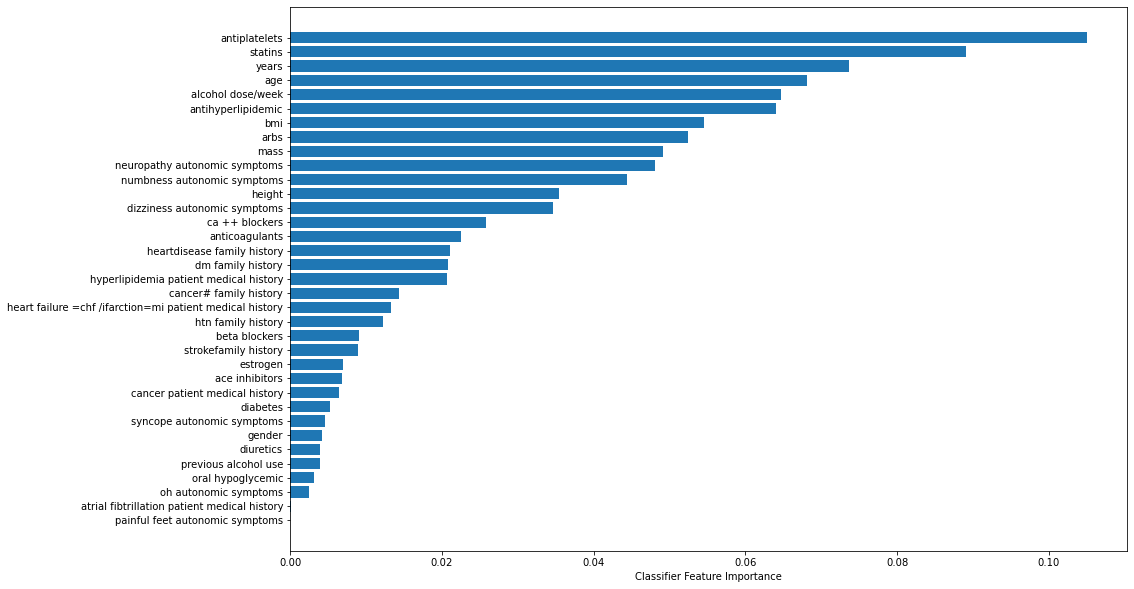

In [63]:
grid_search_res, y_test_pred_rf = search_best_model(X_train, y_train, X_test, y_test, classifier_rf, 3, parameter_grid)

scikit learn computes feature importances as **the mean and standard deviation of accumulation of the impurity decrease within each tree**.

Some features present only few patients within a category and therefore those feature are not informative here. The question is: would it be useful if we had more patients within those categories?
There are 112 patients in total let's compare the feature importance with the number of patients per category

In [64]:
sorted_idx = grid_search_res.best_estimator_.feature_importances_.argsort()
df_features_importance = pd.DataFrame({"columns" : X_stroke_encoded.columns[sorted_idx], 
                                       "importance" : grid_search_res.best_estimator_.feature_importances_[sorted_idx]})

In [65]:
df_features_importance.loc[0:10] #let's see for the first ten with the lowest importance

,columns,importance
0,painful feet autonomic symptoms,0.000000
1,atrial fibtrillation patient medical history,0.000071
2,oh autonomic symptoms,0.002518
3,oral hypoglycemic,0.003121
4,previous alcohol use,0.003936
5,diuretics,0.003942
6,gender,0.004144
7,syncope autonomic symptoms,0.004657
8,diabetes,0.005283
9,cancer patient medical history,0.006489


In [66]:
df_stroke_freq = df_stroke_v1.describe(include="all").loc["freq"].sort_values(ascending=False)
df_stroke_freq[0:10] #top 10 unbalnced categorical feature 

oral hypoglycemic                                           110
heart failure =chf /ifarction=mi patient medical history    109
estrogen                                                    109
diabetes                                                    109
atrial fibtrillation patient medical history                109
painful feet autonomic symptoms                             106
anticoagulants                                              104
arbs                                                        104
antihyperlipidemic                                          103
cancer patient medical history                               99
Name: freq, dtype: object

In [67]:
set(df_stroke_freq[0:10].index) & set(df_features_importance.loc[0:10, 'columns']) #common

{'atrial fibtrillation patient medical history',
 'cancer patient medical history',
 'diabetes',
 'oral hypoglycemic',
 'painful feet autonomic symptoms'}

In [68]:
features_diff_importance = set(df_features_importance.loc[0:10, 'columns']).difference(set(df_stroke_freq[0:10].index))
df_stroke_freq.loc[list(features_diff_importance)]

diuretics                     84
previous alcohol use          83
ace inhibitors                83
syncope autonomic symptoms    93
oh autonomic symptoms         79
gender                        62
Name: freq, dtype: object

We could still argue that if a feature has 80/90 patients with the same category this feature doesn't bring much information. However, this is very surprsising that gender is not part of the most important feature as described in the litterature...

Let's see the 10 most important features

In [69]:
df_features_importance.tail(10)

,columns,importance
25,neuropathy autonomic symptoms,0.048104
26,mass,0.049206
27,arbs,0.052398
28,bmi,0.054489
29,antihyperlipidemic,0.064062
30,alcohol dose/week,0.064750
31,age,0.068167
32,years,0.073619
33,statins,0.089130
34,antiplatelets,0.105045


In [70]:
df_features_importance.head(10)["columns"]

0                 painful feet autonomic symptoms
1    atrial fibtrillation patient medical history
2                           oh autonomic symptoms
3                               oral hypoglycemic
4                            previous alcohol use
5                                       diuretics
6                                          gender
7                      syncope autonomic symptoms
8                                        diabetes
9                  cancer patient medical history
Name: columns, dtype: object

Antiplatelets stop blood clot to form and and statins is a cholesterol-lowering drug. Those medications prevent stroke and are therefore a good indicator of your risk to have a stroke. What could be interesting here is that we smartcompanion could use wheter or not a patient is taking this medication instead of specifying the cholesterol level or other blood measures.

In this top 15, we found the 3 categories of feature: demographic, lifestyle (alcohol consumption), medical record (medication, symptoms).

Interestingly mass and height are all used here even though they are correlated to bmi.

For the further analysis let's try
- use this model on the perfusion dataset
- online clustering


In [71]:
X_stroke_encoded.columns

Index(['age', 'height', 'mass', 'bmi', 'gender', 'years',
       'previous alcohol use', 'alcohol dose/week',
       'neuropathy autonomic symptoms', 'dizziness autonomic symptoms',
       'numbness autonomic symptoms', 'painful feet autonomic symptoms',
       'syncope autonomic symptoms', 'oh autonomic symptoms',
       'cancer# family history', 'heartdisease family history',
       'htn family history', 'dm family history', 'strokefamily history',
       'cancer patient medical history',
       'atrial fibtrillation patient medical history',
       'heart failure =chf /ifarction=mi patient medical history',
       'hyperlipidemia patient medical history', 'diabetes', 'antiplatelets',
       'anticoagulants', 'antihyperlipidemic', 'statins', 'estrogen',
       'ace inhibitors', 'arbs', 'beta blockers', 'diuretics',
       'ca ++ blockers', 'oral hypoglycemic'],
      dtype='object')

In [72]:
X_perfusion_encoded = perfusion_encoded.drop("stroke patient medical history", axis="columns")
X_perfusion_encoded.dropna(inplace=True)

In [73]:
y_perfusion_pred = grid_search_res.best_estimator_.predict(X_perfusion_encoded)
df_perfusion_v1["rf_predictions_class"] = y_perfusion_pred

In [74]:
encoded_dict["stroke patient medical history"]

{'no': 0, 'yes': 1}

In [75]:
pd.Series(y_perfusion_pred).value_counts()

0    28
1    28
dtype: int64

We know that there is no patients that had a stroke in the perfusion datasets. Let's analyze the shap values. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value. 

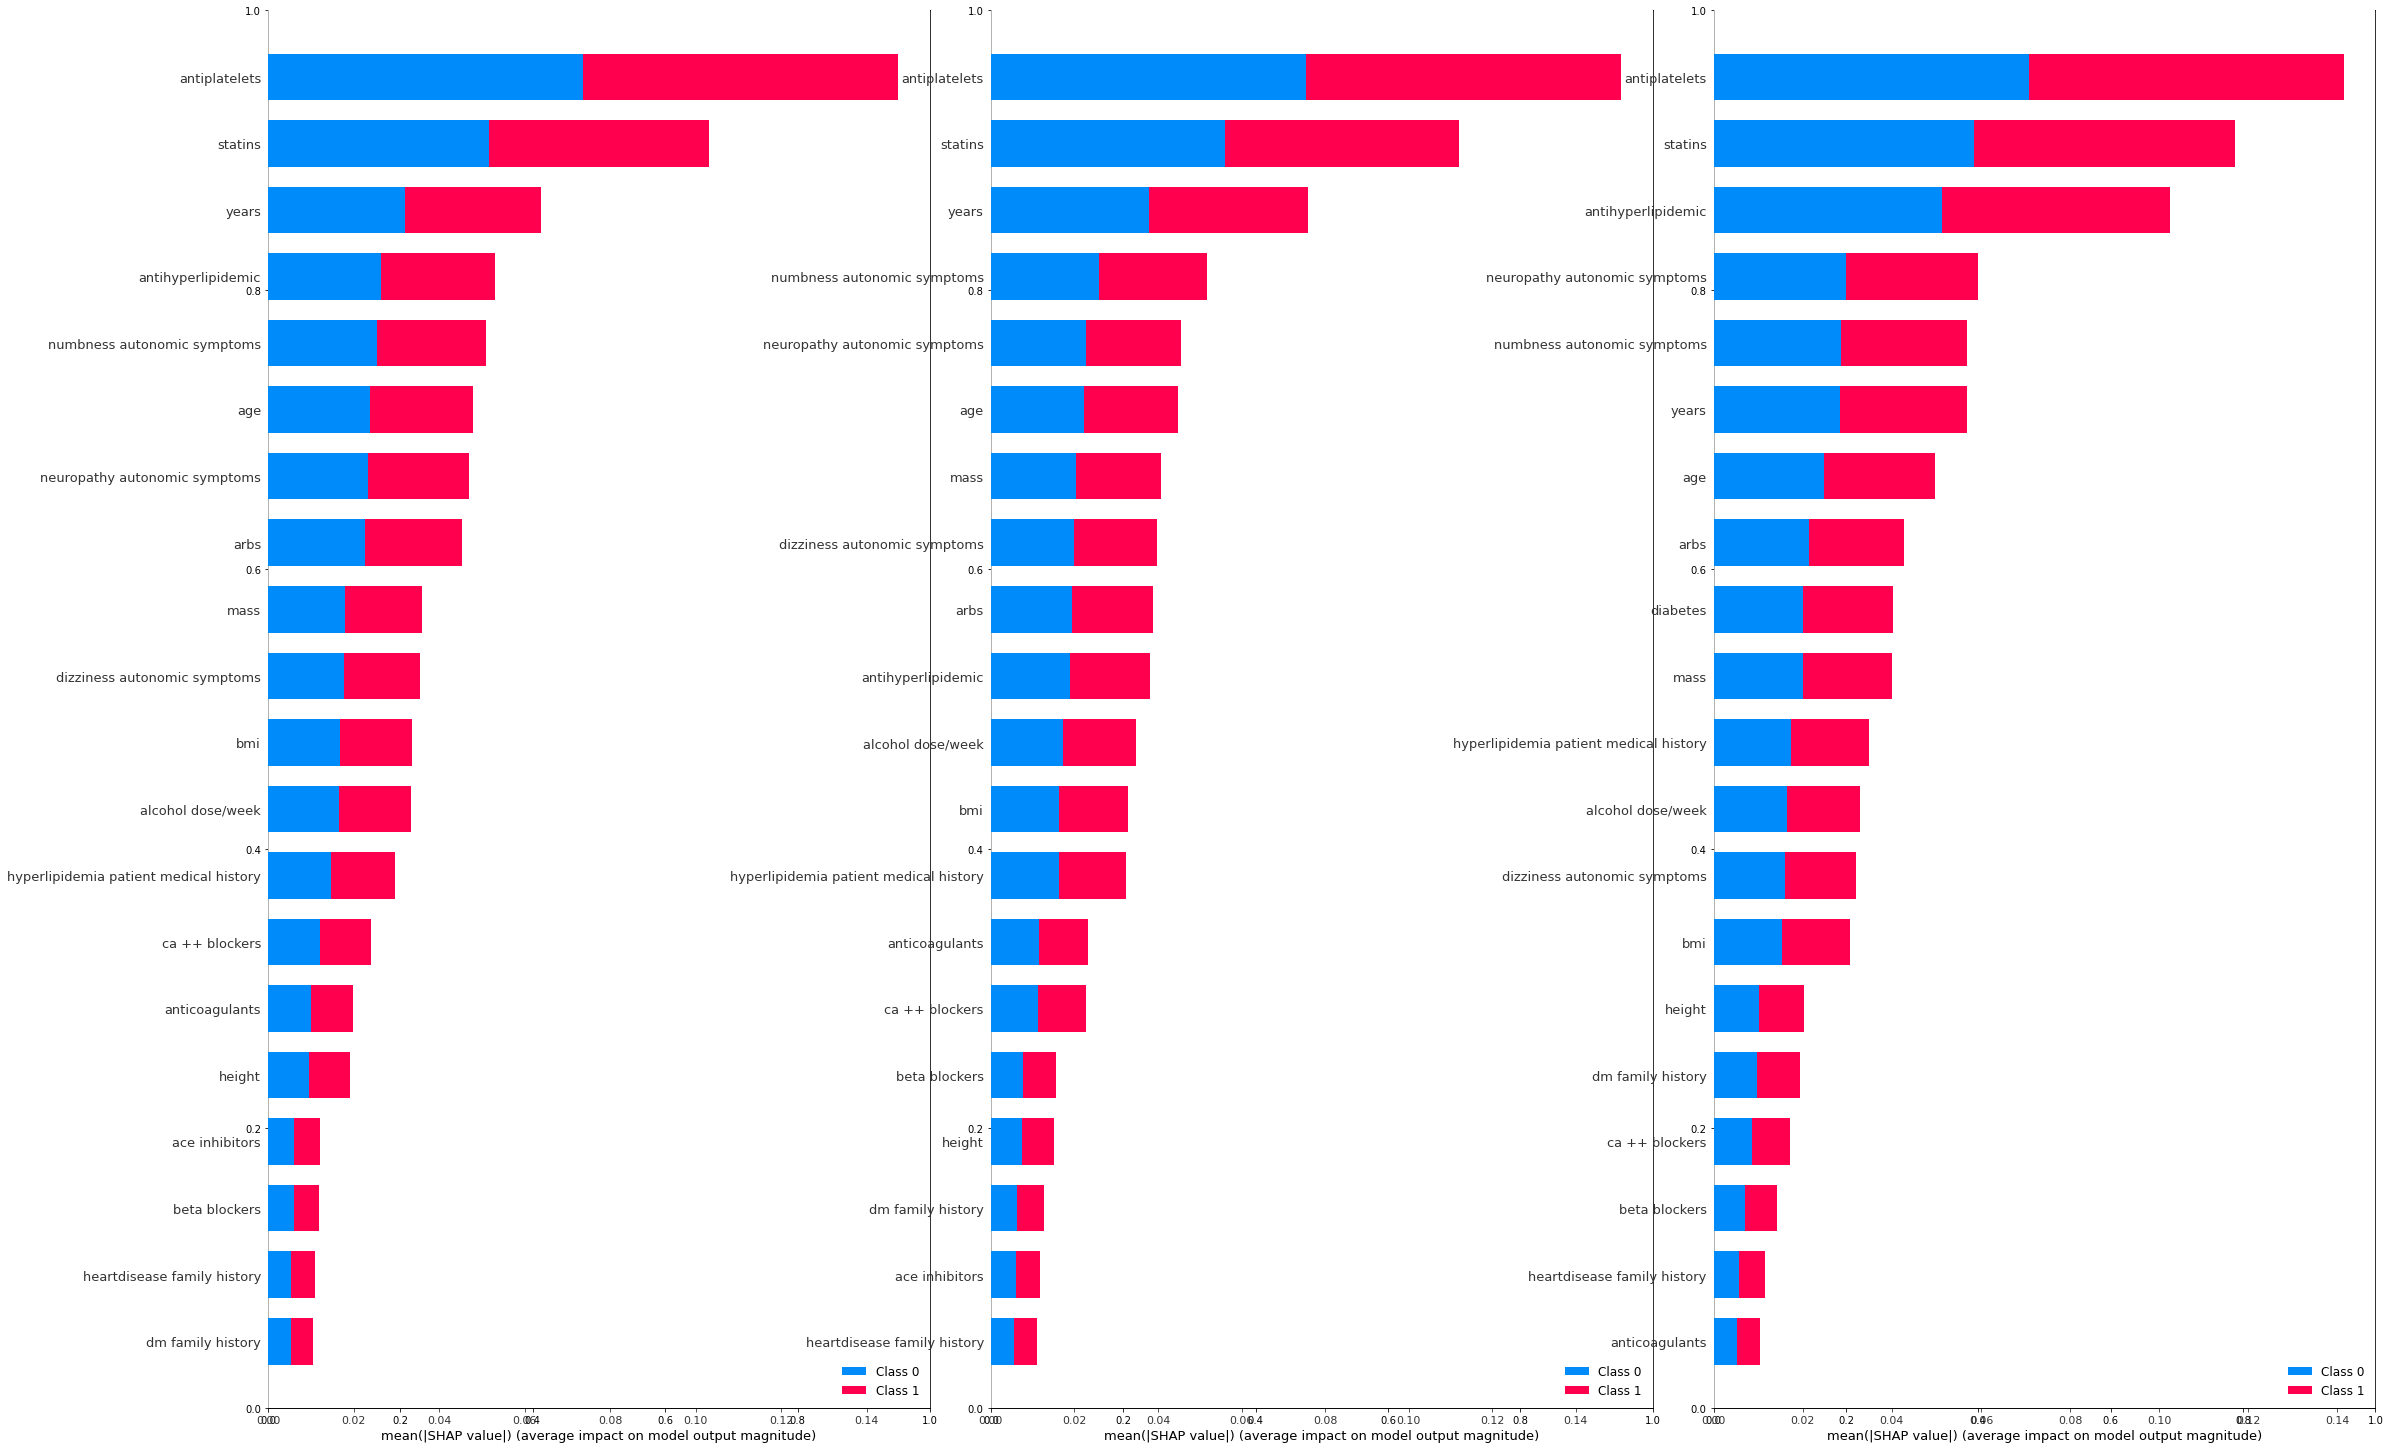

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(30,20))
fig.tight_layout(w_pad=3)

explainer = shap.TreeExplainer(grid_search_res.best_estimator_)

fig.add_subplot(131)
shap_values_train = explainer.shap_values(X_train, y=y_train)
shap.summary_plot(shap_values_train, X_train, plot_type="bar", show=False, plot_size=None)

fig.add_subplot(132)
shap_values_test = explainer.shap_values(X_test, y=y_test)
shap.summary_plot(shap_values_test, X_test, plot_type="bar", show=False, plot_size=None)

fig.add_subplot(133)
shap_values_perfusion = explainer.shap_values(X_perfusion_encoded)
shap.summary_plot(shap_values_perfusion, X_perfusion_encoded, show=False, plot_size=None)

plt.show()

Note: open the image in another window to have a better view.
From left to right we have shap values per features for: 
    - train set
    - test set
    - perfusion set

We see that feature's importance order is different between the 3.
Intersting to see antihyperlimidemic is at the top for train and perfusion but not for test. Another thing, "years" (number of years smoking) is less important than numbness or neuropathy symptoms for the perfusion datasets (filled with diabetic persons). Let's compare now the shap values for X_train, X_test et X_perfusion at patients level    

In [77]:
#see shap values for one specific patient
shap.initjs()
shap_values_ex = explainer.shap_values(X_train.iloc[1:2,])

shap.force_plot(
    explainer.expected_value[1], 
    shap_values_ex[1], 
    X_train.iloc[1:2,])

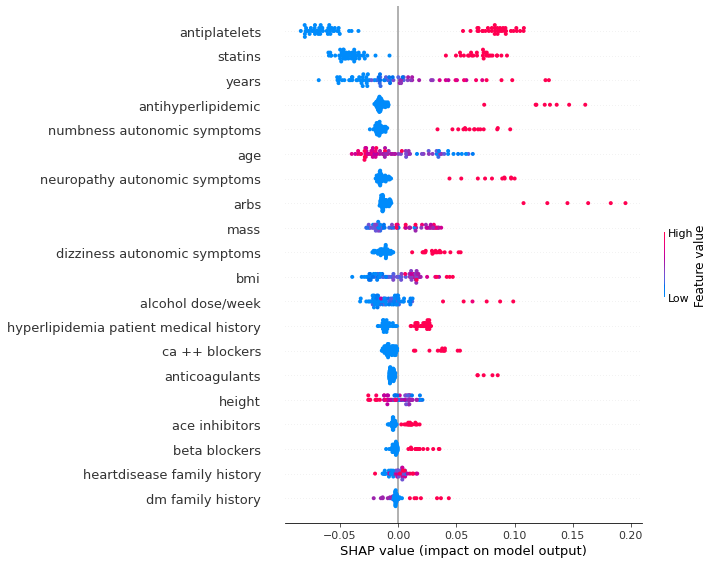

In [78]:
shap.summary_plot(shap_values_train[1], X_train, plot_type="dot")

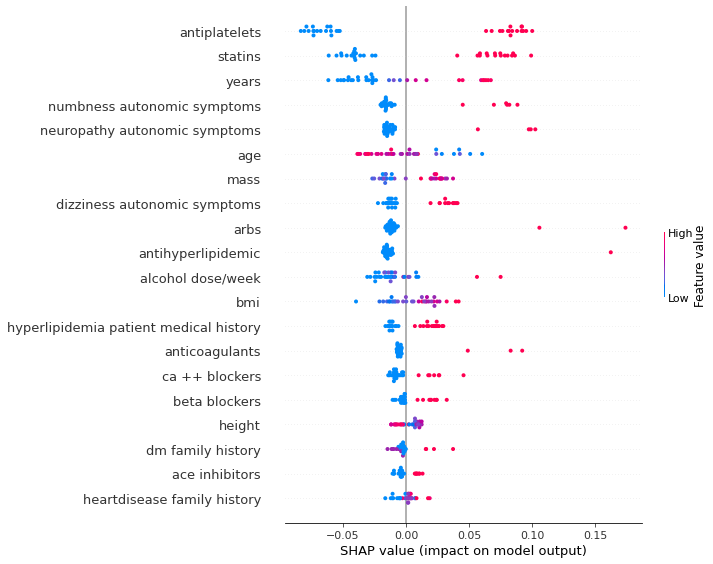

In [79]:
shap.summary_plot(shap_values_test[1], X_test, plot_type="dot")

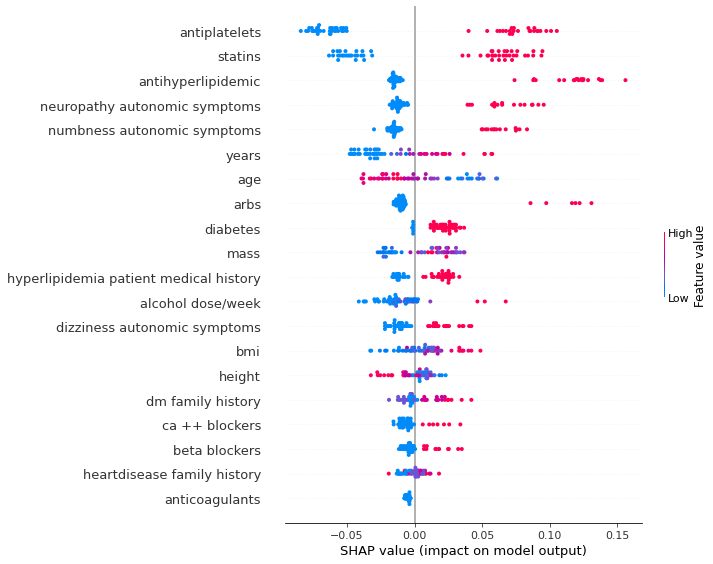

In [80]:
shap.summary_plot(shap_values_perfusion[1], X_perfusion_encoded, plot_type="dot")

Surprinsgly, we see that prediction of having a stroke in the past decreases with age and height Let's see the stroke history distribution by age and height. 

In [81]:
px.histogram(X_train["age"], nbins=10, color=y_train)

In [82]:
((df_stroke_v1["age"] < 70) & (df_stroke_v1["stroke patient medical history"] == "yes")).sum()

34

In [83]:
df_stroke_v1.groupby(["gender", "stroke patient medical history"]).size().unstack(fill_value=0)

stroke patient medical history,no,yes
gender,,
female,38,24
male,26,24


In this dataset it is clear that stroke affects younger patients. According to this article https://jnnp.bmj.com/content/74/3/317 (fig3.A) younger patients tend to have less CVDs events than older patients. There's not enough patients in this dataset to represent this reality.

In [84]:
px.histogram(X_train["height"], color=y_train, nbins=10)

Height is still investigated as a possible risk factor but it is unclear this is not linked to ethnicity, bmi distribution, socialeconomical class in a nutshell a phenomena of multicollinearity. 

Now we want to analyze how the model behaves with diabetic patients without any history of stroke.

In [85]:
encoded_dict["diabetes"]

{'no': 0, 'yes': 1}

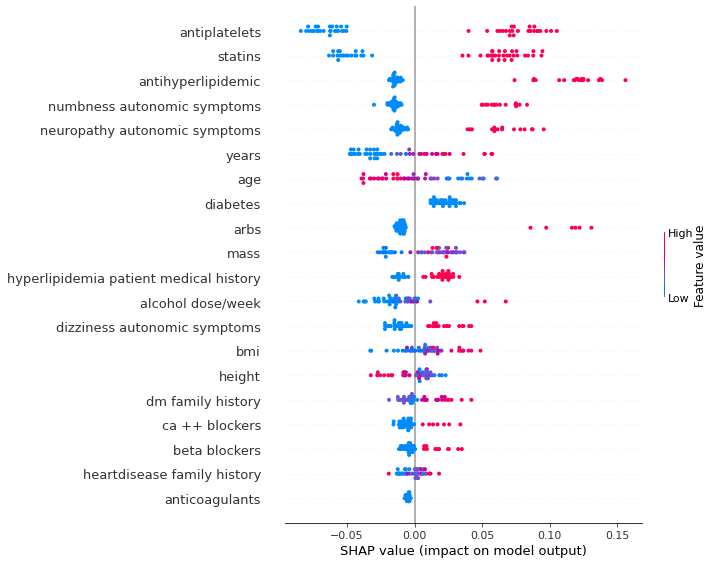

In [86]:
# patient predicted with a history of stroke
X_perfusion_encoded_diabetes = X_perfusion_encoded[X_perfusion_encoded["diabetes"]==1]
shap_values_diabetes = explainer.shap_values(X_perfusion_encoded_diabetes)
shap.summary_plot(shap_values_diabetes[1], 
                  X_perfusion_encoded_diabetes, 
                  plot_type='dot')

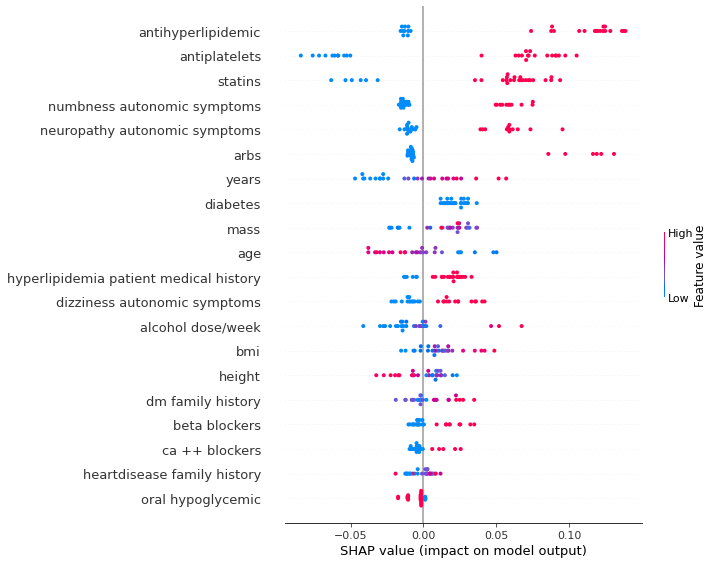

In [87]:
# patient with history of stroke and diabetes (90% dataset)
X_perfusion_encoded_diabetes_stroke = X_perfusion_encoded[(df_perfusion_v1["diabetes"]=="yes") & 
                                                   (y_perfusion_pred == 1)]
shap_values_diabetes_stroke = explainer.shap_values(X_perfusion_encoded_diabetes_stroke)

shap.summary_plot(shap_values_diabetes_stroke[1], 
                  X_perfusion_encoded_diabetes_stroke, 
                  plot_type='dot')

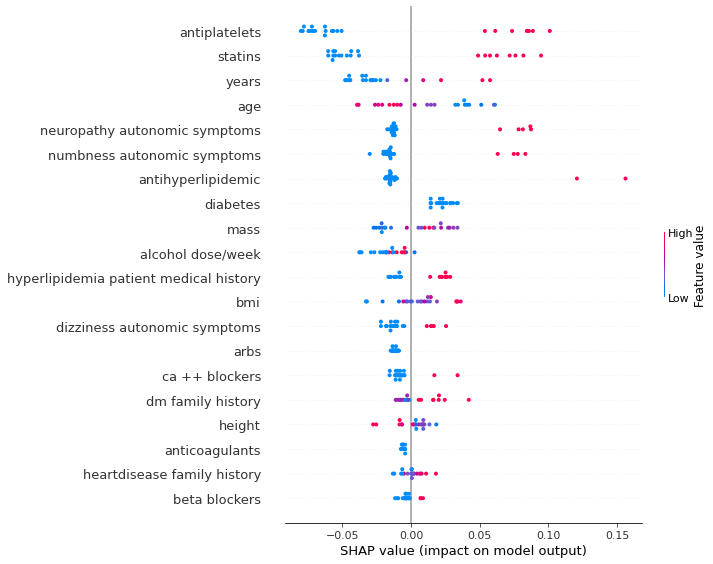

In [88]:
# patient predicted with no history of stroke and diabetes 
X_perfusion_encoded_diabetes_nostroke = X_perfusion_encoded[(X_perfusion_encoded["diabetes"]==1) & 
                                                   (y_perfusion_pred == 0)]
shap_values_diabetes_nostroke = explainer.shap_values(X_perfusion_encoded_diabetes_nostroke)

shap.summary_plot(shap_values_diabetes_nostroke[1], 
                  X_perfusion_encoded_diabetes_nostroke, 
                  plot_type='dot')

In [89]:
df_stroke_v1[df_stroke_v1["diabetes"] == "yes"]["stroke patient medical history"]

patient id
s0231    yes
s0275    yes
s0343     no
Name: stroke patient medical history, dtype: object

For the perfusion datasets hyperlipidemia (medication and diagnosis) is more important for the prediction than in the prediction of the stroke dataset. 

Moreover, from patient to patient the shap values of a specific feature can increase/decrease dramatically compared to shap value plot of stroke dataset. This could mean that patient in the perfusion datasets are different even though they present the same condition.

There were only 3 patients with diabetes in the stroke datasets and 2 of them had a stroke. We can still see that diabetes has some importance for the predictions. 

In [90]:
df_stroke_v1.groupby(["dm family history", "stroke patient medical history"]).size().unstack(fill_value=0)

stroke patient medical history,no,yes
dm family history,,
0.0,45,31
1.0,14,10
2.0,5,3
3.0,0,3
4.0,0,1


In [91]:
y_test_pred_proba = grid_search_res.best_estimator_.predict_proba(X_test)
predictions = pd.DataFrame({"class": y_test_pred_rf,"probability":y_test_pred_proba[:,1]})

In [92]:
px.histogram(predictions["probability"], color=y_test, labels={"value":"prediction probability of past stroke", "color":"ground truth"})

In [93]:
X_train.columns.get_loc("neuropathy autonomic symptoms")

8

In [94]:
px.scatter(x=shap_values_test[1][:,8],
           y=predictions["probability"], 
           color=y_test.astype(str), 
           labels={"y":"probability", "x":"shap values neuropathy autonomic symptoms", "color":"ground truth"})

# Dimensionality Reduction & Clustering

In [95]:
import prince
import umap
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from scipy.cluster import hierarchy
from seaborn import clustermap
import gower
from scipy.spatial.distance import squareform
import phik

In [96]:
# Functions
def get_famd(table):
    famd = prince.FAMD(n_components=3, n_iter=3,
                   copy=True, check_input=True,
                   engine='sklearn',
                   random_state=42)
    famd = famd.fit(table)
    coords = famd.row_coordinates(table)
    return famd, coords

The objective is to 
- reduce the datasets dimensions to 2 or 3 using distance/similarity measures
- find clusters and see features explaning those clusters

Those features could be interpreted as risk or protective factor of stroke
Because we have mixed data we can not apply traditional algorithms

## FAMD

In [97]:
X_stroke = df_stroke_v1.drop(labels="stroke patient medical history", axis="columns")
X_stroke_selected = X_stroke.drop(labels=df_features_importance["columns"].head(10), axis="columns")

In [98]:
X_stroke_selected.shape

(112, 25)

In [99]:
numerical_features = X_stroke_selected.dtypes[X_stroke_selected.dtypes !='object'].index
X_stroke_selected_norm = X_stroke_selected.copy()
X_stroke_selected_norm[numerical_features] = X_stroke_selected_norm.select_dtypes(exclude=['object']).apply(lambda x: (x-x.mean())/ x.std(), axis=0)

<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (13.98% inertia)', ylabel='Component 1 (9.82% inertia)'>

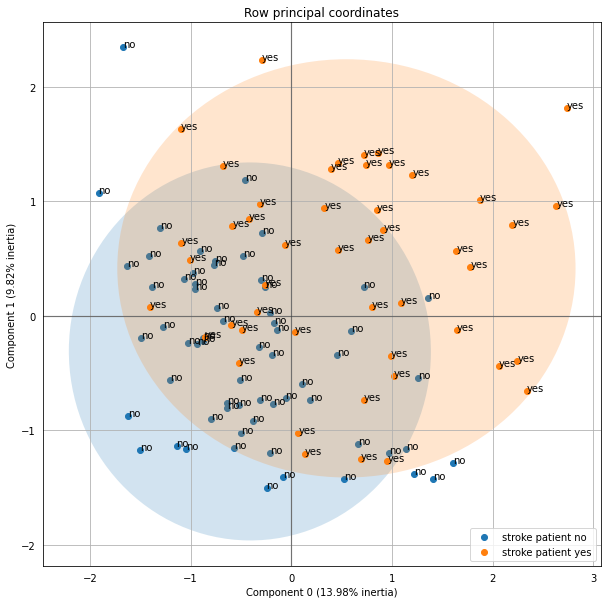

In [100]:
famd, coords = get_famd(X_stroke_selected_norm)
famd.plot_row_coordinates(
     X_stroke_selected,
     ax=None,
     figsize=(10, 10),
     x_component=0,
     y_component=1,
     labels=df_stroke_v1["stroke patient medical history"],
     color_labels=['stroke patient {}'.format(t) for t in df_stroke_v1["stroke patient medical history"]],
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

In [101]:
fig = px.scatter_3d(x=coords[0], y=coords[1], z=coords[2], size_max=15)
fig.update_traces(marker={'size': 3})
fig.show()

In [102]:
(famd.explained_inertia_).sum() #not enough

0.3262572373809337

## UMAP

In [103]:
def umap_embed(df, n_components=2, n_neighbors=10, intersection=False):

    numerical = df.select_dtypes(exclude='object').copy()

    for c in numerical.columns:
        numerical[c] = (numerical[c] - numerical[c].mean())/numerical[c].std(ddof=0)

    ##preprocessing categorical
    categorical = df.select_dtypes(include='object')
    categorical = pd.get_dummies(categorical).copy()

    #Embedding numerical & categorical
    fit1 = umap.UMAP(random_state=12,
                   n_components=n_components).fit(numerical)

    fit2 = umap.UMAP(metric='hamming',
                   n_neighbors=n_neighbors,
                   n_components=n_components).fit(categorical)


    # intersection will resemble the numerical embedding more.
    if intersection:
        embedding = fit1 * fit2

    # union will resemble the categorical embedding more.
    else:
        embedding = fit1 + fit2

    umap_embedding = embedding.embedding_
    return umap_embedding

In [104]:
umap_neighbord10 = umap_embed(X_stroke_selected_norm, intersection=False)

gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable


In [105]:
px.scatter(umap_neighbord10[:, 0], umap_neighbord10[:, 1]).show()

## RandomForestEmbeding

In [106]:
grid_search_res.best_estimator_.fit(X_stroke_encoded, y_stroke_encoded)

RandomForestClassifier(max_depth=4, n_estimators=50, random_state=42)

In [107]:
# computing 2D embedding with tsne, for visualization purposes
leaves = grid_search_res.best_estimator_.apply(X_stroke_encoded)
M = OneHotEncoder().fit_transform(leaves)

# we perform M*M.transpose(), which is the same to 
# computing all the pairwise co-ocurrences in the leaves 
S = (M*M.transpose()).todense()

# lastly, we normalize and subtract from 1, to get dissimilarities
D = 1 - S/S.max()

# TNSE perplexity test
embed_10 = TSNE(n_components=3, 
             metric='precomputed',
             init = "random",
             learning_rate=200,
             square_distances=True,
             perplexity=10).fit_transform(D)

embed_30 = TSNE(n_components=3, 
             metric='precomputed',
             init = "random",
             learning_rate=200,
             square_distances=True,
             perplexity=30).fit_transform(D)

embed_50 = TSNE(n_components=3, 
             metric='precomputed',
             init = "random",
             learning_rate=200,
             square_distances=True,
             perplexity=50).fit_transform(D)

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html


According to the documentation: 

The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results.

In [108]:
fig = px.scatter_3d(x=embed_10[:,0], y=embed_10[:,1], z=embed_10[:,2], size_max=15,
                 color = df_stroke_v1["stroke patient medical history"])
fig.update_traces(marker={'size': 4})
fig.show()

In [109]:
fig = px.scatter_3d(x=embed_30[:,0], y=embed_30[:,1], z=embed_30[:,2], size_max=15,
                 color = df_stroke_v1["stroke patient medical history"])
fig.update_traces(marker={'size': 4})
fig.show()

In [110]:
fig = px.scatter_3d(x=embed_50[:,0], y=embed_50[:,1], z=embed_50[:,2], size_max=15,
                 color = df_stroke_v1["stroke patient medical history"])
fig.update_traces(marker={'size': 4})
fig.show()

Change cohesion/density but no apparent clusters.

Now let's visualize the dissimilarity matrix on a heatmap and try different distance matrix

### Distance 

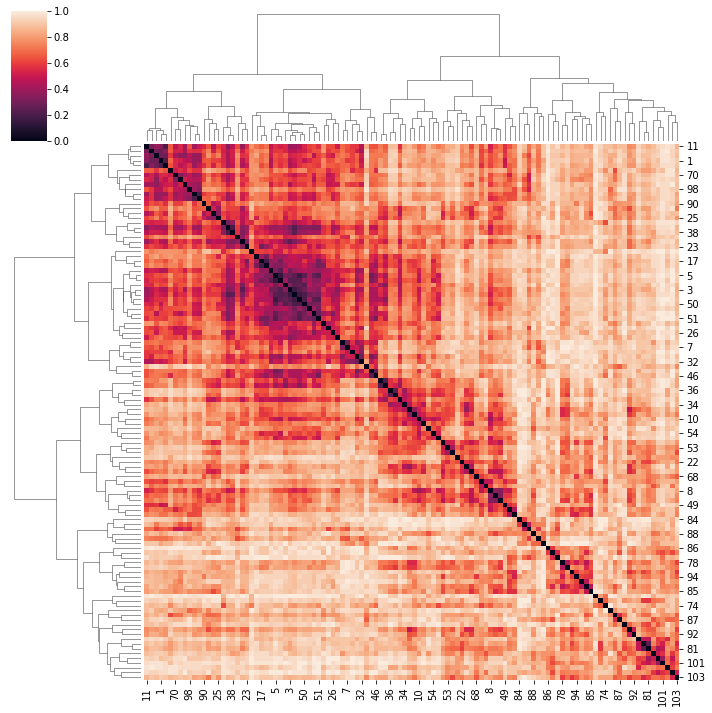

In [111]:
D_vector = squareform(D)
distLinkage = hierarchy.linkage(D_vector, "ward")
clustermap(D, row_linkage=distLinkage, col_linkage=distLinkage)

<AxesSubplot:>

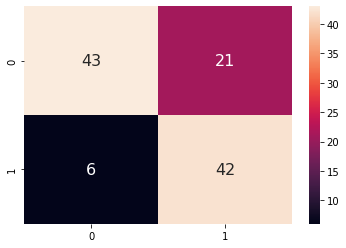

In [112]:
clusters_2 = hierarchy.cut_tree(distLinkage, n_clusters=2, height=None)
cm=metrics.confusion_matrix(y_stroke_encoded,clusters_2[:,0])
sns.heatmap(cm, annot=True, annot_kws={"size": 16}) 

Accuracy of (43+42)/112=0.76, this is equel to the accuracy of the random forest algorithm. It makes sense since the distance is based on the algorithm

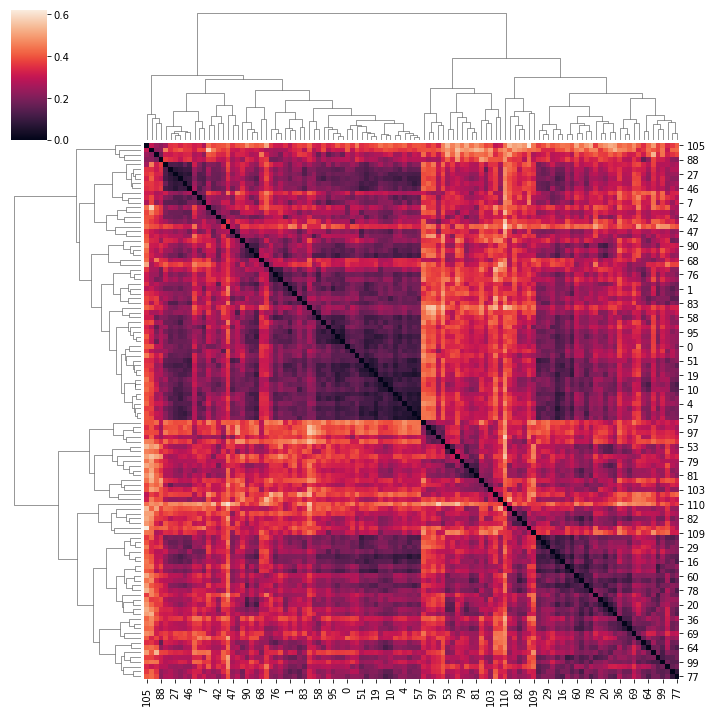

In [113]:
stroke_gower_matrix = gower.gower_matrix(X_stroke_selected_norm)
stroke_gower_vector = squareform(stroke_gower_matrix)
distLinkage_gower= hierarchy.linkage(stroke_gower_vector, "ward")
clustermap(stroke_gower_matrix, row_linkage=distLinkage_gower, col_linkage=distLinkage_gower)

<AxesSubplot:>

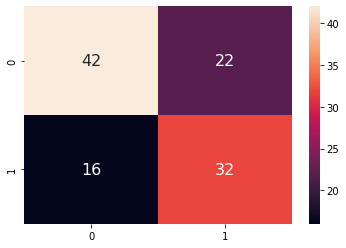

In [114]:
clusters_2_gower = hierarchy.cut_tree(distLinkage_gower, n_clusters=2, height=None)
cm_gower=metrics.confusion_matrix(y_stroke_encoded,clusters_2_gower[:,0])
sns.heatmap(cm_gower, annot=True, annot_kws={"size": 16}) 

Results are less accurate than when we used the distance computed by the randomforest algorithm.

## Number of Cluster

In [115]:
# Function for plotting elbow curve
def plot_elbow_curve(start, end, data, model, categorical_index=[]):
    no_of_clusters = list(range(start, end+1))
    cost_values = []
    
    for k in no_of_clusters:
        if model == "kprototypes":
            test_model = KPrototypes(n_clusters=k, init='Huang', random_state=42)
            test_model.fit_predict(data, categorical=categorical_index)
        if model == "kmodes":
            test_model = KModes(n_jobs = -1, n_clusters = k, init = 'Huang', random_state = 0)
            test_model.fit_predict(data)
        cost_values.append(test_model.cost_)
        
    sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
    
    plt.figure(figsize=(15, 7))
    ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
    ax.set_title('Elbow curve', fontsize=18)
    ax.set_xlabel('No of clusters', fontsize=14)
    ax.set_ylabel('Cost', fontsize=14)
    ax.set(xlim=(start-0.1, end+0.1))
    plt.plot();

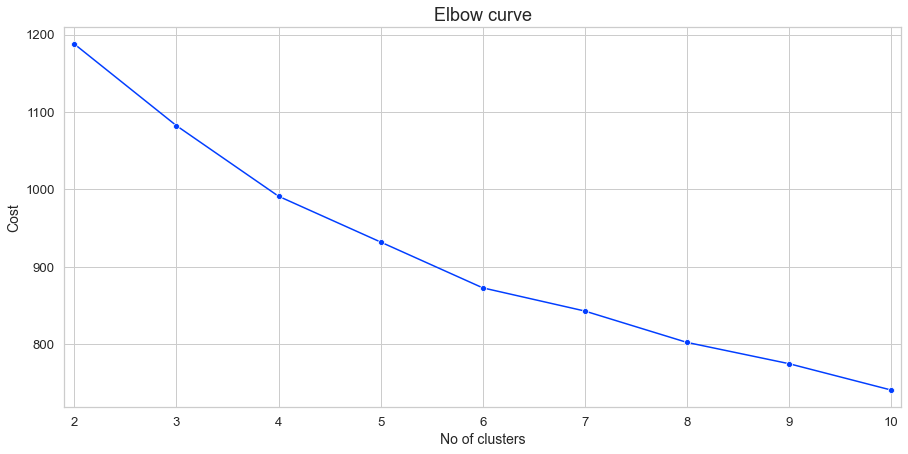

In [116]:
categorical_features = X_stroke_selected_norm.dtypes[X_stroke_selected.dtypes == 'object'].index
categorical_features_idx = []

for col in categorical_features:
    categorical_features_idx.append(X_stroke_selected_norm.columns.get_loc(col))
    
 
# Plotting elbow curve for k=2 to k=10
plot_elbow_curve(2,10, X_stroke_selected_norm, "kprototypes", categorical_features_idx )

## K-prototypes

In [117]:
model_4 = KPrototypes(n_clusters=4, init='Huang', random_state=42, n_jobs=-1)
model_4.fit_predict(X_stroke_selected, categorical=categorical_features_idx)
print(model_4.cost_)
#new column for cluster labels associated with each subject
model_4_results = X_stroke_selected.copy()
model_4_results['labels4'] = model_4.labels_

33866.84283627349


In [118]:
model4_groundtruth = pd.DataFrame({"ground_truth":y_stroke_encoded,
              'clustering':model_4_results['labels4']
             })
model4_groundtruth.groupby(["ground_truth", 'clustering']).size().unstack(fill_value=0)

clustering,0,1,2,3
ground_truth,,,,
0,13,11,0,40
1,11,14,6,17


We see a subgroup of 6 patients that only contains stroke patients. Let's see if those are the same patients, false negatives of the hierarchical clustering using the random forest distance.

In [119]:
cluster4_grp2_index = model4_groundtruth[(model4_groundtruth["clustering"]==2) &
                  (model4_groundtruth["ground_truth"]==1)].index
hc2_fn_ground_truth = pd.DataFrame({'ground_truth':y_stroke_encoded,
             'clusters_2':clusters_2[:,0]})
fn_index = hc2_fn_ground_truth[(hc2_fn_ground_truth["ground_truth"]==1)
   & (hc2_fn_ground_truth["clusters_2"]==0)].index

In [120]:
set(cluster4_grp2_index) & set(fn_index)

set()

None are common between the two clustering. In any case, this clustering doesn't aggregate stroke and non stroke patient.
This shows that in this dataset patients are different by other factors than stroke history. This is surprising because those patients have been chosen to assess difference between stroke patient and non even though they have been specifically chosen. 

# Perfusion Dataset

In [121]:
y_perfusion_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [122]:
pd.Series(y_perfusion_pred).value_counts()

0    28
1    28
dtype: int64

In [123]:
df_perfusion_v1["diabetes"].value_counts()

yes    50
no      6
Name: diabetes, dtype: int64

In [124]:
pred_diabetes = df_perfusion_v1.copy()
pred_diabetes["pred"] = y_perfusion_pred
pred_diabetes.groupby(["diabetes", 'pred']).size().unstack(fill_value=0)

pred,0,1
diabetes,,
no,6,0
yes,22,28


As expected, even though those patients never had a stroke, they are at high risk and are half are predicted to have had a stroke.

In [125]:
famd, coords = get_famd(df_perfusion_v1)
fig = px.scatter_3d(x=coords[0], y=coords[1], z=coords[2], size_max=15)
fig.update_traces(marker={'size': 3})
fig.show()

In [126]:
(famd.explained_inertia_).sum() #not enough

0.3398300621122793

In [127]:
numerical_features_perfusion = df_perfusion_v1.dtypes[df_perfusion_v1.dtypes !='object'].index
categorical_features_perfusion = df_perfusion_v1.dtypes[df_perfusion_v1.dtypes == object].index
df_perfusion_v1_norm = df_perfusion_v1.copy()
df_perfusion_v1_norm[numerical_features_perfusion] = df_perfusion_v1_norm[numerical_features_perfusion].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

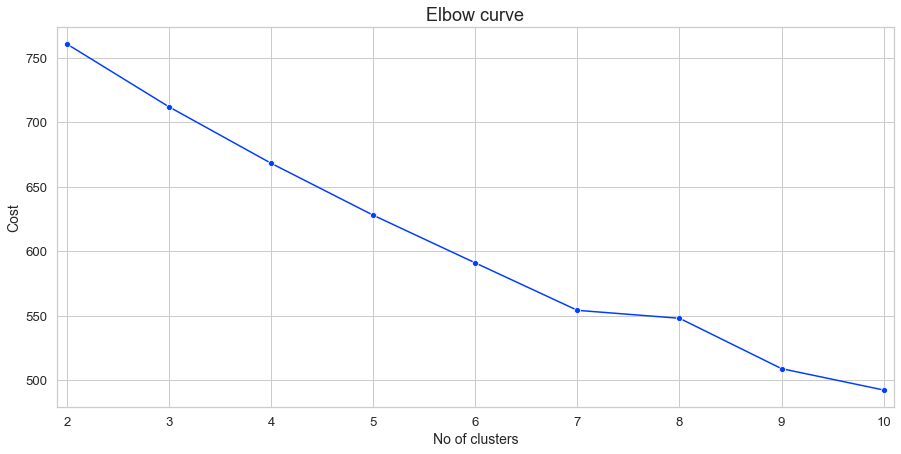

In [128]:
categorical_features_perfusion_index = []

for col in categorical_features_perfusion:
    categorical_features_perfusion_index.append(df_perfusion_v1_norm.columns.get_loc(col))

plot_elbow_curve(2, 10, df_perfusion_v1_norm, "kprototypes", categorical_features_perfusion_index)

There is no elbow showing. This doesn't mean there is no cluster but maybe the algorithm used is not the correct one

# Transforming all variables in categorical features

https://www.euro.who.int/en/health-topics/disease-prevention/nutrition/a-healthy-lifestyle/body-mass-index-bmi
We could: 
- drop height and mass which are redundant to bmi 
- use the bmi's categories from the who 
- age: test binning in 10 years or split >65
- transform history to yes or no 
- frequency binning for the rest


In [129]:
get_unique_value_col(df_perfusion_v1[numerical_features_perfusion])

,unique_value
diabetes duration,"[7.0, 0.0, 3.0, 1.0, 16.0, 4.0, 18.0, 2.0, 15.0, 5.0, 9.0, 10.0, 21.0, 6.0, 12.0, 37.0, 28.0, 17.0, 32.0, 20.0, 8.0]"
age,"[50, 69, 78, 55, 67, 57, 68, 58, 62, 83, 73, 66, 59, 71, 65, 74, 53, 52, 51, 64, 77, 80, 70, 72, 63]"
height,"[1.79, 1.531, 1.52, 1.7, 1.5, 1.68, 1.807, 1.63, 1.608, 1.62, 1.602, 1.6, 1.54, 1.57, 1.66, 1.85, 1.46, 1.9, 1.59, 1.84, 1.8, 1.75, 1.53, 1.76, 1.64, 1.72, 1.56, 1.78, 1.83, 1.82, 1.74, 1.55, 1.61, 1.818, 1.768, 1.667, 1.727]"
mass,"[114.65, 56.9, 65.77, 70.31, 83.46, 71.67, 85.8, 63.5, 56.25, 69.2, 48.99, 52.25, 65.65, 54.43, 88.8, 64.75, 74.6, 84.1, 95.4, 91.4, 65.2, 94.65, 74.25, 79.6, 84.0, 124.0, 79.8, 91.3, 81.95, 77.95, 84.9, 83.5, 95.25, 130.7, 89.6, 65.35, 63.8, 91.1, 81.15, 77.5, 100.3, 78.8, 93.55, 121.6, 68.0, 69.0, 69.85, 86.85, 85.3, 133.05, 92.85, 72.3, 80.74]"
bmi,"[35.782279, 24.2751479, 28.4669321, 24.3287197, 37.0933333, 25.3932823, 26.2767097, 23.9000339, 24.3464335, 26.7629514, 21.2041205, 19.9093126, 25.5805399, 23.5586911, 25.6914062, 37.4430764, 26.2688142, 27.072144, 31.6534307, 27.8743608, 32.3837868, 30.5873522, 26.2188366, 29.3698825, 27.5432526, 24.8109641, 38.2716049, 26.0571429, 39.0020932, 26.4559659, 31.624001, 27.6063355, 28.6979448, 34.3113083, 30.0624921, 40.3395062, 26.7550539, 25.5273437, 22.6048753, 35.5859375, 24.4988528, 25.5978333, 33.1285507, 23.0241052, 20.8326531, 33.1455499, 45.7676239, 26.5625, 26.2917238, 23.6107355, 36.1498439, 32.907681, 40.2556757, 29.7041676, 26.0175919, 27.0709857]"
pack years,"[2.86, 0.14, 0.0, 34.0, 15.0, 60.0, 30.0, 25.0, 4.29, 10.0, 5.71, 20.0, 8.57, 57.0, 80.0, 26.0, 40.0, 61.5, 45.0, 7.5, 1.25, 0.5]"
years,"[10.0, 1.0, 0.0, 17.0, 15.0, 40.0, 30.0, 25.0, 20.0, 57.0, 26.0, 41.0, 5.0]"
alcohol dose/week,"[7.0, 0.5, 9.0, 0.0, 1.0, 70.0, 4.0, 14.0, 2.0, 35.0, 3.0, 25.0, 0.25, 5.0]"
cancer# family history,"[1.0, 0.0, 2.0, 3.0]"
heartdisease family history,"[1.0, 3.0, 0.0, 2.0]"


In [130]:
df_perfusion_v1_bin = df_perfusion_v1.copy()
df_perfusion_v1_bin.drop(labels=["mass", "height", "pack years", "years", "alcohol dose/week"], axis="columns", inplace=True)
 
df_perfusion_v1_bin.loc[(df_perfusion_v1_bin["age"] >= 65), "age"] = ">=65"
df_perfusion_v1_bin.loc[(df_perfusion_v1_bin["age"] != ">=65"), "age"] = "<65"

history = ["cancer# family history", "heartdisease family history", "htn family history", "dm family history", "strokefamily history"]
for el in history:
    df_perfusion_v1_bin.loc[(df_perfusion_v1_bin[el] == 0.0), el] = "no"
    df_perfusion_v1_bin.loc[(df_perfusion_v1_bin[el] != "no"), el] = "yes"

    
frequency_binning = ["diabetes duration"]
cut_bin_dict = {}
for el in frequency_binning:
    df_perfusion_v1_bin[el], cut_bin = pd.qcut(df_perfusion_v1_bin[el], q = 3, labels = ['C', 'B', 'A'], retbins = True)
    cut_bin_dict[el] = cut_bin

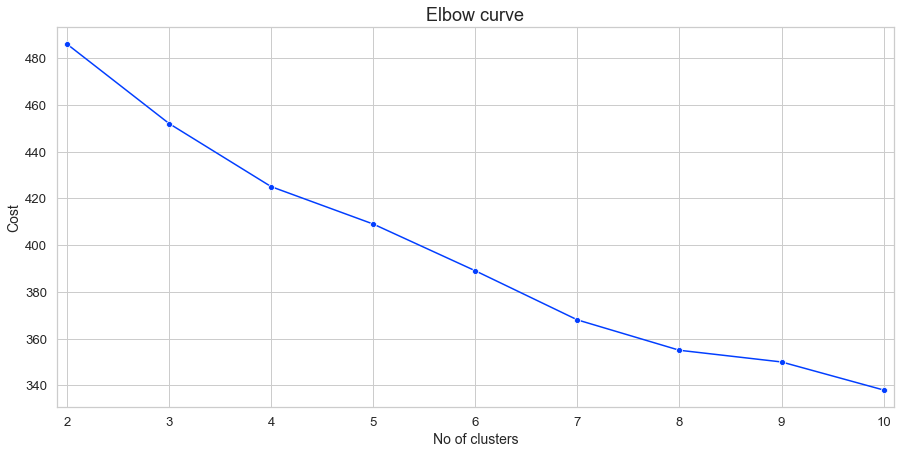

In [131]:
plot_elbow_curve(2, 10, df_perfusion_v1_bin, "kmodes")

# Trying with less features
We know that some features are not important for the prediciton of stroke or not stroke (see random forest features importance chart). We know that some of the features are correlated: bmi, height, mass.

In [132]:
np.sqrt(df_perfusion_v1.shape[0])

7.483314773547883

In [133]:
df_features_importance.tail(10)["columns"]

25    neuropathy autonomic symptoms
26                             mass
27                             arbs
28                              bmi
29               antihyperlipidemic
30                alcohol dose/week
31                              age
32                            years
33                          statins
34                    antiplatelets
Name: columns, dtype: object

In [134]:
perfusion_selected_norm = df_perfusion_v1_norm[df_features_importance.tail(10)["columns"]].copy()
perfusion_selected_norm.drop("mass", axis="columns", inplace=True)

interval columns not set, guessing: ['bmi', 'alcohol dose/week', 'age', 'years']


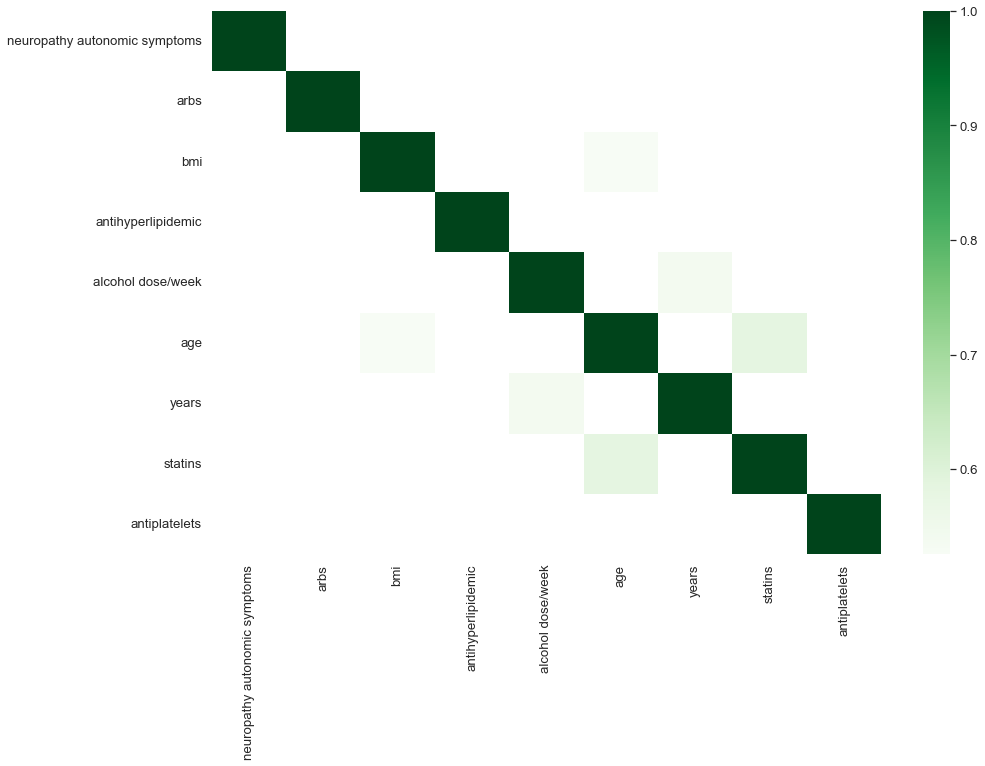

In [135]:
corr_phik = perfusion_selected_norm.phik_matrix()
plt.figure(figsize=(15,10))
sns.heatmap(corr_phik[abs(corr_phik) >= 0.5], cmap="Greens")
plt.show()

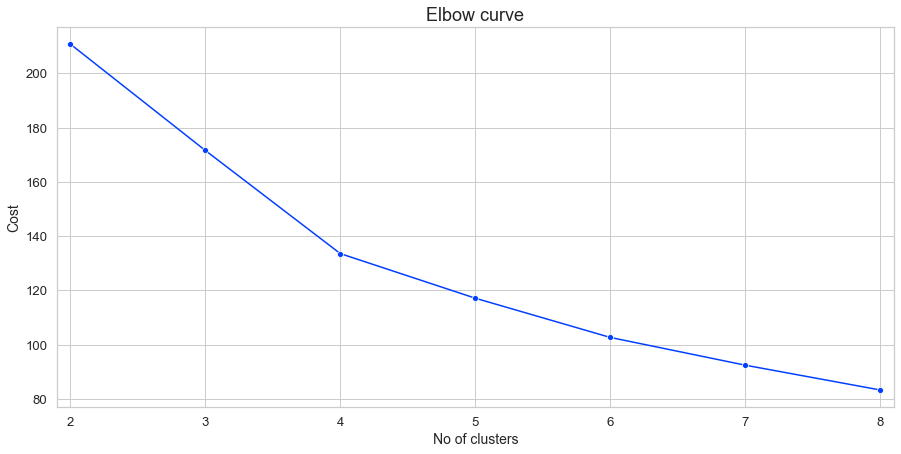

In [136]:
categorical_features = perfusion_selected_norm.dtypes[perfusion_selected_norm.dtypes == 'object'].index
categorical_features_idx = []

for col in categorical_features:
    categorical_features_idx.append(perfusion_selected_norm.columns.get_loc(col))
    
# Plotting elbow curve for k=2 to k=8
plot_elbow_curve(2,8, perfusion_selected_norm, "kprototypes", categorical_features_idx )

In [137]:
cluster_perfusion_4 = KPrototypes(n_clusters=2, init='Huang', random_state=42, n_jobs=-1)
cluster_perfusion_4.fit_predict(perfusion_selected_norm, categorical=categorical_features_idx)
print(model_4.cost_)

33866.84283627349


In [138]:
pd.DataFrame({"predictions":y_perfusion_pred,
              'clustering': cluster_perfusion_4.labels_
             }).groupby(["predictions", 'clustering']).size().unstack(fill_value=0)

clustering,0,1
predictions,,
0,15,13
1,15,13


# Neural Network

In [139]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau
from plotly.subplots import make_subplots

In [140]:
#Functions 

def get_metrics(hst):
  """
  hst: hystory from the training and testing
  save all the metrics in a pandas dataframe
  """
  m_metrics = pd.DataFrame(hst.history)
  m_metrics.insert(0, column='Epochs', value=range(1, len(m_metrics)+1))
  return m_metrics


def plot_metrics(model):
  """
  shows two plots as a function of epochs
    - loss
    - accuracy 
  for training and validation set 
  """
  fig = make_subplots(rows=1, cols=2, x_title="epochs",  subplot_titles=("loss", "accuracy"))
  fig.add_scatter(x=model['Epochs'], y=model["loss"], row=1, col=1, name="loss")
  fig.add_scatter(x=model['Epochs'], y=model["val_loss"], row=1, col=1, name="val loss")
  fig.add_scatter(x=model['Epochs'], y=model["accuracy"], row=1, col=2, name="accuracy")
  fig.add_scatter(x=model['Epochs'], y=model["val_accuracy"], row=1, col=2, name="val accuracy").show()
 
 
def define_model(nb=32):
  model = Sequential()
  model.add(InputLayer(input_shape=X_train.shape[1]))
  model.add(Dense(2*nb, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(nb, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(1, activation="sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(),tf.keras.metrics.AUC()])
  return model

In [141]:
X_train.shape

(78, 35)

In [142]:
epochs = 50
batch_size = 16
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2,patience=3, min_lr=0.001, min_delta=0.02)

In [143]:
model_stroke = define_model(nb=16)
history = model_stroke.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=0, 
                    validation_data=(X_test,y_test),
                    callbacks=[reduce_lr])
model_stroke.summary()

2022-05-11 09:50:55.910348: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-11 09:50:56.278627: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,697
Trainable params: 1,697
Non-trainable params: 0
_________________________________________________________________


In [144]:
model_metrics = get_metrics(history)
plot_metrics(model_metrics)

In [155]:
perfusion_nn_perdictions = model_stroke.predict(X_perfusion_encoded)
df_perfusion_v1["nn_predictions_prob"] = perfusion_nn_perdictions
df_perfusion_v1["nn_predictions_class"] = [1 if el > 0.5 else 0 for el in df_perfusion_v1["nn_predictions_prob"]]


# Embeding

In [157]:
model2 = Sequential()
model2.add(InputLayer(input_shape=X_train.shape[1]))
model2.add(Dense(32, activation='relu', weights=model_stroke.layers[0].get_weights()))
model2.add(Dense(16, activation='relu', weights=model_stroke.layers[1].get_weights()))
model2.compile()

layer_2_activations = model2.predict(X_perfusion_encoded)

In [159]:
tsne_layer_2 = TSNE(n_components=3,
    init = "random",
    learning_rate="auto",
    square_distances=True,
    perplexity=10, 
    random_state=42).fit_transform(layer_2_activations)

fig = px.scatter_3d(x=tsne_layer_2[:,0], 
                    y=tsne_layer_2[:,1], 
                    z=tsne_layer_2[:,2], 
                    size_max=15, 
                    color=df_perfusion_v1["nn_predictions_class"].astype("category"))

fig.update_traces(marker={'size': 4})
fig.show()

In [173]:
pca_layer_2 = PCA()
pca_layer_2.fit(layer_2_activations)
pc_layer_2 = pca_layer_2.transform(layer_2_activations)

In [174]:
px.scatter_3d(x=pc_layer_2[:,0], 
            y=pc_layer_2[:,1], 
            z=pc_layer_2[:,2], 
            color=df_perfusion_v1["nn_predictions_class"].astype("category")).update_traces(marker={'size': 4}) 
            


In [175]:
(pca_layer_2.explained_variance_ratio_)

array([6.0354930e-01, 2.1501334e-01, 1.0063234e-01, 3.9243571e-02,
       1.8463852e-02, 8.5519524e-03, 6.6663749e-03, 4.0398319e-03,
       2.7391587e-03, 1.1003277e-03, 7.1377423e-18, 1.2839319e-18,
       1.8367356e-20, 1.0813700e-34, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [176]:
model3 = Sequential()
model3.add(InputLayer(input_shape=X_train.shape[1]))
model3.add(Dense(32, activation='relu', weights=model_stroke.layers[0].get_weights()))
model3.compile()

layer_1_activations = model3.predict(X_perfusion_encoded)

In [177]:
tsne_layer_1 = TSNE(n_components=3,
    init = "random",
    learning_rate="auto",
    square_distances=True,
    perplexity=10).fit_transform(layer_2_activations)

fig = px.scatter_3d(x=tsne_layer_1[:,0], y=tsne_layer_1[:,1], z=tsne_layer_1[:,2], size_max=15)
fig.update_traces(marker={'size': 4})
fig.show()

In [180]:
pca_layer_1 = PCA()
pca_layer_1.fit(layer_1_activations)
pc_layer_1 = pca_layer_1.transform(layer_1_activations)

px.scatter_3d(x=pc_layer_1[:,0], 
            y=pc_layer_1[:,1], 
            z=pc_layer_1[:,2], 
            color=df_perfusion_v1["nn_predictions_class"].astype("category")).update_traces(marker={'size': 4})


In [183]:
pca_layer_1.explained_variance_ratio_

array([6.5882194e-01, 1.7887209e-01, 1.0965284e-01, 2.2460070e-02,
       1.1024745e-02, 5.8945916e-03, 3.9317426e-03, 1.9359259e-03,
       1.4599789e-03, 1.2642384e-03, 8.9372153e-04, 8.3177013e-04,
       6.7388802e-04, 5.8090006e-04, 5.3542125e-04, 3.5028523e-04,
       2.4376161e-04, 1.9131930e-04, 1.5762866e-04, 1.0148824e-04,
       4.3922042e-05, 4.2484862e-05, 3.5024234e-05, 2.9171241e-07,
       2.0104956e-15, 2.0104956e-15, 2.0104956e-15, 2.0104956e-15,
       2.0104956e-15, 2.0104956e-15, 2.0104954e-15, 1.2125235e-15],
      dtype=float32)